# Tutorial de ejecución del experimento

**Trabajo Fin de Grado**: Herramientas para garantizar justicia en aprendizaje automático

**Autor**: Daniel Bolaños Martínez

Importaremos las bibliotecas utilizadas a lo largo del experimento, entre las cuales se encuentran:

* Pandas 1.2.4
* NumPy 1.19.2
* Scikit-learn 0.24.2
* matplotlib 3.4.3
* seaborn 0.11.2
* Aequitas 0.42.0
* pathlib2 2.3.6
* Módulos usados incluidos en Python: pickle, copy, os.

Además se ha utilizado el módulo PyStan 2.19.1.1 que funciona como una interfaz de Python para el lenguaje de programación probabilística Stan (https://mc-stan.org). El cual permite generar muestras de datos a partir de métodos que trabajan con cadenas de Markov (como MCMC) y crear modelos causales sobre los que operar gracias a la inferencia estadística Bayesiana.

In [1]:
import os
import shutil
import pystan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle
from pathlib import Path
import seaborn as sns
import copy
import matplotlib.pyplot as plt

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

## Modelos de equidad contrafactual

*Basado en el trabajo de Counterfactual Fairness de Kusner et al. (2018)*

**Descripción del conjunto de datos utilizado**: El Consejo de Admisión de las Facultades de Derecho realizó una encuesta en 163 facultades de Derecho de Estados Unidos. Contiene información sobre 21.790 estudiantes de Derecho, tales como las puntuaciones de su examen de acceso (LSAT), su media del expediente (GPA) antes de entrar en la facultad, y su nota media del primer año (FYA) en la carrera de Derecho. A partir de estos datos, una escuela querría predecir si un solicitante tendrá un FYA alto.

### Implementación y diseño de los modelos

En primer lugar, definiremos aquellas funciones que se utilizarán para el tratamiento de los datos:

La función $\texttt{preprocess_data}$ realiza las siguientes funciones:

* Categorizar cada valor del atributo raza obteniendo una columna para que cada tipo de raza, tome el valor 1 o 0 para cada individuo, señalando la pertenencia o no del mismo a la raza indicada por la columna específica $\texttt{get_dummies}$.
* Sustituir el atributo sexo por dos columnas ('Male'-'Female') que indiquen con 1 o 0 la característica del individuo concreto.
* Discretizar el valor de 'LSAT' (convertir cada valor a tipo entero).
* Agrupar los individuos de raza mexicana y puertorriqueña en la raza hispánica, y los de raza amerindia en otras.

In [2]:
# Preprocesamiento del conjunto de datos 'law_data.csv'
def preprocess_data(data, protected_attr):    

    data['race'] = data['race'].apply(lambda a: 'Hispanic' if a == 'Mexican' else a)
    data['race'] = data['race'].apply(lambda a: 'Hispanic' if a == 'Puertorican' else a)
    data['race'] = data['race'].apply(lambda a: 'Other' if a == 'Amerindian' else a)
    data['first_pf'] = data['first_pf'].apply(lambda a: 0 if a == 0.0 else 1)
    
    # Convertimos la columna 'LSAT' a tipo entero
    data['LSAT'] = data['LSAT'].apply(lambda a: int(a))
    
    # Creamos una columna que indique con 0 o 1 la pertenencia al sexo Masculino o Femenino
    data['Female'] = data['sex'].apply(lambda a: 1 if a == 1 else 0)
    data['Male'] = data['sex'].apply(lambda a: 1 if a == 2 else 0)
    
    # Creamos una columna que indique con 0 o 1 la pertenencia al sexo Masculino o Femenino
    data['sex'] = data['sex'].apply(lambda a: 'Male' if a == 2 else 'Female')

    # Realizamos una división 80-20 de los conjuntos de entrenamiento y test
    train, test = train_test_split(data, random_state = 76592621, train_size = 0.8);
    
    train_orig = copy.deepcopy(train)
    test_orig  = copy.deepcopy(test)
    
    # Separamos cada atributo de raza en una columna con 1 si el individuo 
    # pertenece a ella o 0 si el individuo no pertenece
    train = pd.get_dummies(train, columns=['race'], prefix='', prefix_sep='')
    test = pd.get_dummies(test, columns=['race'], prefix='', prefix_sep='')
    train = train.drop(['sex'], axis=1)  
    test = test.drop(['sex'], axis=1)  
    
    # Creamos un diccionario compatible con pystan para los conjuntos creados anteriormente
    dic_train = create_pystan_dic(train, protected_attr)
    dic_test = create_pystan_dic(test, protected_attr)

    return dic_train, dic_test, train_orig, test_orig

Además, utilizaremos la función $\texttt{create_pystan_dic}$ para crear un diccionario que contendrá las siguientes características del conjunto de datos:

* **N** - Número total de ejemplos para ese diccionario.
* **C** - Número de categorías diferentes de atributos sensibles.
* **A** - Array con el contenido de cada una de las filas de los atributos protegidos.
* **GPA** - Array con los valores de UGPA.
* **LSAT** - Array con los valores de LSAT.
* **FYA** - Array con los valores de ZFYA.

Esta elección la realizamos, ya que el método StanModel, que construye el modelo causal, trabaja con diccionarios en Python.

In [3]:
# Crea un diccionario compatible con pystan para el conjunto de datos y los atributos protegidos dados
def create_pystan_dic(data, protected_attr, train=True):
    dic_data = {}
    dic_data['N'] = len(data)
    dic_data['C'] = len(protected_attr)
    dic_data['A'] = np.array(data[protected_attr])
    dic_data['GPA'] = list(data['UGPA'])
    dic_data['LSAT'] = list(data['LSAT'])
    if train:
        dic_data['FYA'] = list(data['ZFYA'])
    
    return dic_data

Para la evaluación posterior de cada modelo, leeremos el conjunto de datos original y trataremos los datos tal y cómo hemos explicado previamente.

In [4]:
    data = pd.read_csv('./datos/law_data.csv', index_col=0)    
    
    # Guardamos en un vector todos los atributos protegidos
    protected_attr = ['Asian','Black','Hispanic','Other','White','Male','Female']

    # Obtiene en un diccionario el conjunto de datos y en una partición 80 (train) 20 (test)
    dic_train, dic_test, train, test = preprocess_data(data, protected_attr)

Antes que nada, podemos estudiar la correlación entre los diferentes atributos del conjunto de datos:

In [5]:
# Definimos la función para mostrar la matriz de correlación
def MatrizCorrelacion(data):
    data = pd.get_dummies(data, columns=['race'], prefix='', prefix_sep='')
    data = data.drop(['sex'], axis=1)
    correlations = data.corr()
    fig, ax = plt.subplots(figsize=(18,18))
    sns.heatmap(correlations, linewidths=0.125, ax=ax)
    plt.show()

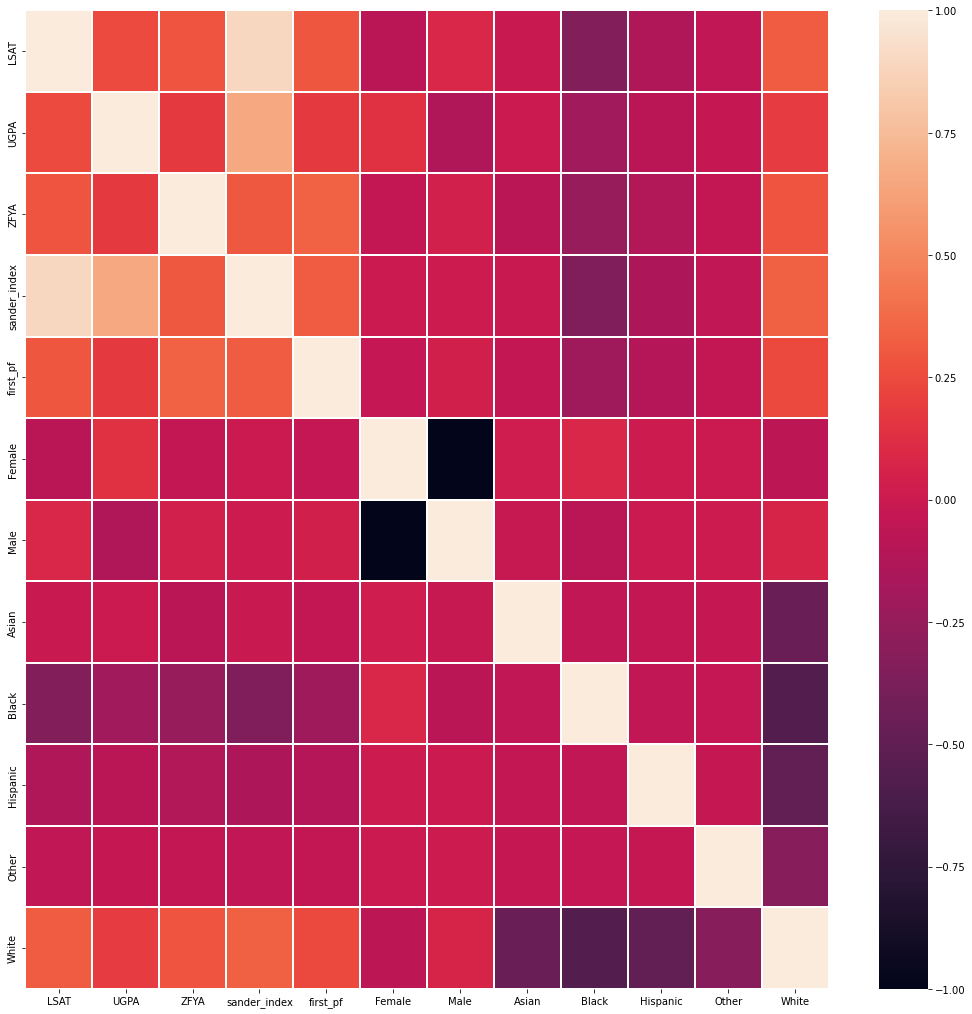

In [6]:
# Mostramos la matriz de correlación
MatrizCorrelacion(train)

#### Modelo Completo

Utilizará todas las características disponibles para el individuo, incluidos los atributos sensibles. Usaremos los datos de entrenamiento relativos a los atributos protegidos y los valores de GPA y LSAT. Construiremos el modelo completo, y usaremos el regresor lineal para entrenarlo. Una vez hecho esto, podremos calcular las predicciones sobre el conjunto de datos de prueba.

In [7]:
# Modelo Completo: usa todos los atributos para la predicción
def mod_full(dic_train, dic_test):
    # Construcción de los conjuntos de entrenamiento y tests para el modelo
    x_train = np.hstack((dic_train['A'], np.array(dic_train['GPA']).reshape(-1,1), 
                         np.array(dic_train['LSAT']).reshape(-1,1)))
    x_test = np.hstack((dic_test['A'], np.array(dic_test['GPA']).reshape(-1,1), 
                        np.array(dic_test['LSAT']).reshape(-1,1)))
    y = dic_train['FYA']

    # Entrenamiento del modelo sobre el conjunto x_train
    lr_full = LinearRegression()
    lr_full.fit(x_train, y)
    
    # Predicción de las etiquetas sobre el conjunto x_test
    preds_test = lr_full.predict(x_test)
    
    # Predicción de las etiquetas sobre el conjunto x_train
    preds_train = lr_full.predict(x_train)
    
    # Cálculo del score sobre el conjunto x_test
    score = lr_full.score(x_test, dic_test['FYA'])

    return preds_test, preds_train, score

Ejecutamos el modelo sobre los datos tal y como hemos detallado. Finalmente calculamos el valor de RMSE y el coeficiente de determinación ($R^2$) para el modelo en cuestión:

In [8]:
    # Obtiene las predicciones para el modelo
    preds_full_test, preds_full_train, score_full = mod_full(dic_train, dic_test)
    # Imprime los valores de RMSE y score resultantes
    print('Full RMSE: %.4f' % np.sqrt(mean_squared_error(preds_full_test, dic_test['FYA'])))
    print('Full score: %.4f' % score_full)

Full RMSE: 0.8720
Full score: 0.1440


#### Modelo por Desconocimiento

Aplicaremos la noción de equidad por desconocimiento discutida en el proyecto. Usaremos los valores de LSAT y GPA del conjunto de entrenamiento para entrenar el modelo. Finalmente, comprobaremos su actuación sobre el conjunto de datos de prueba. En este caso, no utilizamos los atributos protegidos en el entrenamiento.

In [9]:
# Modelo equidad por desconocimiento: no usa los atributos sensibles en predicción
def mod_unaware(dic_train, dic_test):
    # Construcción de los conjuntos de entrenamiento y tests para el modelo
    x_train = np.hstack((np.array(dic_train['GPA']).reshape(-1,1), 
                         np.array(dic_train['LSAT']).reshape(-1,1)))
    x_test = np.hstack((np.array(dic_test['GPA']).reshape(-1,1), 
                        np.array(dic_test['LSAT']).reshape(-1,1)))
    y = dic_train['FYA']
    
    # Entrenamiento del modelo sobre el conjunto x_train
    lr_unaware = LinearRegression()
    lr_unaware.fit(x_train, y)
    
    # Predicción de las etiquetas sobre el conjunto x_test
    preds_test = lr_unaware.predict(x_test)
    
    # Predicción de las etiquetas sobre el conjunto x_train
    preds_train = lr_unaware.predict(x_train)
    
    # Cálculo del score sobre el conjunto x_test
    score = lr_unaware.score(x_test, dic_test['FYA'])

    return preds_test, preds_train, score

Ejecutamos el modelo y calculamos el valor de RMSE y $R^2$:

In [10]:
    # Obtiene las predicciones para el modelo
    preds_unaware_test, preds_unaware_train, score_unaware = mod_unaware(dic_train, dic_test)
    # Imprime los valores de RMSE y score resultantes
    print('Unaware RMSE: %.4f' % np.sqrt(mean_squared_error(preds_unaware_test, dic_test['FYA'])))
    print('Unaware score: %.4f' % score_unaware)

Unaware RMSE: 0.8916
Unaware score: 0.1051


#### Modelo de variable latente (*Fair K*)

Supondremos que una variable de ruido: los conocimientos del estudiante (*K*), afecta a las puntuaciones de GPA, LSAT y FYA. Emplearemos las siguientes distribuciones:
\begin{equation*}
    \begin{split}
        \text{GPA} &\sim \mathcal{N}(b_G+K \textbf{w}^K_G+[A_R,A_S] \textbf{w}^A_G, \sigma_G),\\
        \text{LSAT} &\sim Poisson(\text{exp}(b_L+K \textbf{w}^K_L +[A_R,A_S] \textbf{w}^A_L)),\\ 
        \text{FYA}&\sim \mathcal{N}(K \textbf{w}^K_F+[A_R,A_S] \textbf{w}^A_F, 1),\\
        \text{K}&\sim \mathcal{N}(0,1).
    \end{split}
    \end{equation*}
    
Realizamos la inferencia sobre este modelo utilizando un conjunto de entrenamiento observado para estimar la distribución posterior de $K$.

Para la creación de este modelo, definiremos las siguientes funciones:

Obtenemos las muestras para un modelo Stan con los datos contenidos en el diccionario. Construiremos el modelo usando la función $\texttt{StanModel}$ de la biblioteca PyStan, lo entrenaremos haciendo uso del método $\texttt{sampling}$ y finalmente extraeremos las muestras con $\texttt{extract}$. Usaremos 2000 iteraciones y 1 cadena de Markov para replicar el ejemplo de Kusner. Para evitar ejecutar el modelo cada vez, guardaremos los modelos entrenados usando las funciones $\texttt{load}$ y $\texttt{dump}$ del módulo $\texttt{pickle}$.

In [11]:
    def MCMC(dic_post, path_model, path_stan):
        model_fit = Path(path_model)

        # Comprobamos si ya existe un archivo con el modelo entrenado
        if model_fit.is_file():
            file = open(path_model, "rb")
            fit_samples = pickle.load(file)
        else:
            # Obtiene muestras desde cero a partir del modelo pasado como parámetro
            model = pystan.StanModel(file = path_stan)
            fit_data = model.sampling(data = dic_post, seed=76592621, chains=1, iter=2000)
            fit_samples = fit_data.extract()
            # Guardamos el modelo entrenado
            file = open(path_model, "wb")
            pickle.dump(fit_samples, file, protocol=-1)

        return fit_samples

Creamos un diccionario con la media de los parámetros obtenidos en el entrenamiento previo del modelo, almacenados en $\texttt{samples}$. Mantendremos la estructura del diccionario para los datos de prueba para los parámetros que no varíen como son $[N, C, A, GPA, LSAT]$ y haremos la media para el resto de parámetros que no dependan de FYA, a saber $[\textbf{w}^K_G, \textbf{w}^A_G, \textbf{w}^K_L, \textbf{w}^A_L, \sigma_G, b_G, b_L]$.

In [12]:
    def get_mean_params(samples, dic):
        dic_data = {}
        # Añadimos los parámetros comunes que comparte con el diccionario original    
        param_base = ['N', 'C', 'A', 'GPA', 'LSAT']
        for param in param_base:
            dic_data[param] = dic[param]

        # Guardamos la media del vector de valores para los parámetros que utiliza el modelo '*only_k.stan'
        for param in samples.keys():
            if param not in ['K', 'wK_F', 'wA_F', 'sigma2_G', 'lp__']:
                dic_data[param] = np.mean(samples[param], axis=0)

        return dic_data

Utilizamos el método $\texttt{MCMC}$ sobre el modelo $\texttt{law_school_train.stan}$ para obtener las muestras para cada punto del conjunto de datos de entrenamiento. Guardamos la media de la variable $K$ para train. Usamos la distribución de $K$ aprendida y hacemos las medias del resto de variables para el conjunto de prueba. Volvemos a inferir sobre el modelo esta vez usando $\texttt{law_school_only_k.stan}$ para el conjunto de prueba. Finalmente, calculamos la media de la variable $K$ para test y la devolveremos junto con la de train.

In [13]:
    def fair_learning(dic_train, dic_test):
        modelos_dir = Path("./datos/modelos")

        # Comprobamos si ya existe un archivo con el modelo entrenado
        if not modelos_dir.exists():
            crear_borrar_directorio(modelos_dir, True)

        # Entrenamos el modelo utilizando el MCMC y obtenemos las muestras para cada punto
        train_samples = MCMC(dic_train, "./datos/modelos/train_k_model.pkl", "./datos/stan/law_school_train.stan")

        # Obtenemos la media de la variable K para train
        train_k = np.mean(train_samples["K"], axis=0).reshape(-1, 1)

        # Usamos la distribución de K aprendida y hacemos las medias del resto de variables para test
        dic_means = get_mean_params(train_samples, dic_test)

        # Volvemos a inferir sobre el modelo esta vez usando el modelo sin FYA para test
        test_samples = MCMC(dic_means, "./datos/modelos/test_k_model.pkl", "./datos/stan/law_school_only_k.stan")
        # Obtenemos la media de la variable K para test
        test_k = np.mean(test_samples["K"], axis=0).reshape(-1, 1)

        return train_k, test_k

Usaremos los arrays con las medias de la variable $K$ inferida en el método anterior, para el conjunto de entrenamiento y el conjunto de prueba. Entrenaremos el modelo haciendo uso de la información contenida en $\texttt{train_k}$ y las etiquetas reales de FYA. Finalmente usaremos el regresor lineal para calcular las predicciones sobre el conjunto de prueba.

In [14]:
    # Modelo no determinista: suponemos variable de ruido 'K' para generar la distribución del resto
    def mod_fair_k(dic_train, dic_test):
        train_k, test_k = fair_learning(dic_train, dic_test)
        
        # Construcción de los conjuntos de entrenamiento y tests para el modelo
        x_train = train_k
        x_test = test_k
        y = dic_train['FYA']

        # Entrenamiento del modelo sobre el conjunto x_train
        lr_fair_k = LinearRegression()
        lr_fair_k.fit(x_train, y)

        # Predicción de las etiquetas sobre el conjunto x_test
        preds_test = lr_fair_k.predict(x_test)

        # Predicción de las etiquetas sobre el conjunto x_train
        preds_train = lr_fair_k.predict(x_train)

        # Cálculo del score sobre el conjunto x_test
        score = lr_fair_k.score(x_test, dic_test['FYA'])

        return preds_test, preds_train, score

Ejecutamos el modelo y calculamos el valor de RMSE y $R^2$:

In [15]:
    # Obtiene las predicciones para el modelo
    preds_fair_k_test, preds_fair_k_train, score_fair_k = mod_fair_k(dic_train, dic_test)
    # Imprime los valores de RMSE y score resultantes
    print('Fair K RMSE: %.4f' % np.sqrt(mean_squared_error(preds_fair_k_test, dic_test['FYA'])))
    print('Fair K score: %.4f' % score_fair_k)

Fair K RMSE: 0.9312
Fair K score: 0.0239


#### Modelo de error aditivo (*Fair Add*)

Modelaremos las puntuaciones de GPA, LSAT y FYA como variables continuas con términos de error aditivos independientes de la raza y el sexo. Estimamos los términos de error $\epsilon_G$, $\epsilon_L$ ajustando primero dos modelos que utilizan la raza y el sexo para predecir individualmente el GPA y LSAT. A continuación, calculamos los residuos de cada modelo (aplicando por ejemplo, $\epsilon_G =\text{GPA}-\hat{Y}_{\text{GPA}}(A_R, A_S)$). Finalmente, utilizaremos las estimaciones residuales de $\epsilon_G$, $\epsilon_L$ para predecir FYA. En este caso las distribuciones vienen dadas por:

   \begin{equation*}
    \begin{split}
        \text{GPA} &= b_G+[A_R,A_S] \textbf{w}^A_G +\epsilon_G, \ \ \epsilon_G \sim P(\epsilon_G)\\
        \text{LSAT} &= b_L+[A_R,A_S] \textbf{w}^A_L +\epsilon_L, \quad \epsilon_L \sim P(\epsilon_L),\\
        \text{FYA}&= b_F+[A_R,A_S] \textbf{w}^A_F +\epsilon_F, \quad \epsilon_F \sim P(\epsilon_F).
    \end{split}
    \end{equation*}
    
Para la creación de este modelo, definiremos las siguientes funciones:

Estima el error $\epsilon$, entrenando el modelo utilizando el conjunto total de datos ($\texttt{dic_train+dic_test}$) para una variable observada $\texttt{var}$ usando además los atributos protegidos. Calculamos los residuos de cada modelo como $$\epsilon_{\texttt{var}} = \texttt{var} - \hat{Y}_\texttt{var}\text{(A)},$$ donde $\texttt{var}$ puede tomar el valor de LSAT o GPA.

In [16]:
    def calculate_eps(dic_train, dic_test, var):
        # Reconstruimos el conjunto total para las variables que vamos a usar
        data_a = np.vstack((dic_train['A'], dic_test['A']))
        data_var = dic_train[var] + dic_test[var]

        # Entrenamos un modelo para estimar el error para el parámetro var
        lr_eps = LinearRegression()
        lr_eps.fit(data_a, data_var)

        # Calculamos los residuos de cada modelo como eps_var = var - Ŷ_var(A)
        eps_train = dic_train[var] - lr_eps.predict(dic_train['A'])
        eps_test = dic_test[var] - lr_eps.predict(dic_test['A'])

        return eps_train, eps_test

Definimos una función auxiliar para mostrar las distribuciones de las gráficas de los residuos para las variables GPA y LSAT.

In [17]:
    # Calcula los histogramas para los errores de cada variable calculada
    def graph_eps(eps_train_G, eps_train_L, eps_test_G, eps_test_L):
        eps_G = np.vstack((eps_train_G.reshape(-1,1), eps_test_G.reshape(-1,1)))
        eps_L = np.vstack((eps_train_L.reshape(-1,1), eps_test_L.reshape(-1,1)))
        plt.subplot(1, 2, 1)
        plt.hist(eps_G, color="red", bins=100)
        plt.title("$\epsilon_{GPA}$")
        plt.xlabel("$\epsilon_{GPA}$")
        plt.subplot(1, 2, 2)
        plt.hist(eps_L, color="green", bins=100)
        plt.title("$\epsilon_{LSAT}$")
        plt.xlabel("$\epsilon_{LSAT}$")
        plt.show()

Estimamos el error para GPA ($\epsilon_\text{GPA}$) y LSAT ($\epsilon_\text{LSAT}$) para el conjunto de entrenamiento utilizando el método previo. Usamos los valores de $\epsilon_\text{GPA}$ y $\epsilon_\text{LSAT}$ para entrenar el modelo. Finalmente, usaremos el regresor lineal para calcular las predicciones sobre el conjunto de datos de prueba. 

In [18]:
    # Modelo determinista: añadimos términos de error aditivos independientes de los atributos protegidos
    def mod_fair_add(dic_train, dic_test):
        # Estimamos el error para GPA
        eps_train_G, eps_test_G = calculate_eps(dic_train, dic_test, 'GPA')
        # Estimamos el error para LSAT
        eps_train_L, eps_test_L = calculate_eps(dic_train, dic_test, 'LSAT')

        graph_eps(eps_train_G, eps_train_L, eps_test_G, eps_test_L)

        x_train = np.hstack((eps_train_G.reshape(-1,1), eps_train_L.reshape(-1,1)))
        x_test = np.hstack((eps_test_G.reshape(-1,1), eps_test_L.reshape(-1,1)))
        y = dic_train['FYA']

        # Entrenamiento del modelo usando los errores de train
        lr_fair_add =  LinearRegression()
        lr_fair_add.fit(x_train, y)

        # Predicción de las etiquetas usando los errores para test
        preds_test = lr_fair_add.predict(x_test)

        # Predicción de las etiquetas usando los errores para test
        preds_train = lr_fair_add.predict(x_train)

        # Cálculo del score sobre el conjunto x_test
        score = lr_fair_add.score(x_test, dic_test['FYA'])

        return preds_test, preds_train, score

Ejecutamos el modelo y calculamos el valor de RMSE y $R^2$:

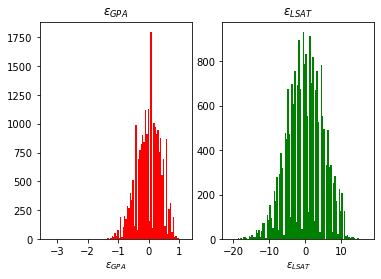

Fair Add RMSE: 0.9191
Fair Add score: 0.0490


In [19]:
    # Obtiene las predicciones para el modelo
    preds_fair_add_test, preds_fair_add_train, score_fair_add = mod_fair_add(dic_train, dic_test)
    # Imprime los valores de RMSE y score resultantes
    print('Fair Add RMSE: %.4f' % np.sqrt(mean_squared_error(preds_fair_add_test, dic_test['FYA'])))
    print('Fair Add score: %.4f' % score_fair_add)

Finalmente mostraremos todos los resultados para el RMSE y el $R^2$ para los cuatro modelos definidos:

In [20]:
    # Imprime los valores de RMSE y score resultantes
    print("Valores RMSE:\n")
    print('Full RMSE: %.4f' % np.sqrt(mean_squared_error(preds_full_test, dic_test['FYA'])))
    print('Unaware RMSE: %.4f' % np.sqrt(mean_squared_error(preds_unaware_test, dic_test['FYA'])))
    print('Fair K RMSE: %.4f' % np.sqrt(mean_squared_error(preds_fair_k_test, dic_test['FYA'])))
    print('Fair Add RMSE: %.4f' % np.sqrt(mean_squared_error(preds_fair_add_test, dic_test['FYA'])))
    print("\nValores Coeficiente de determinación:\n")
    print('Full score: %.4f' % score_full)
    print('Unaware score: %.4f' % score_unaware)
    print('Fair K score: %.4f' % score_fair_k)
    print('Fair Add score: %.4f' % score_fair_add)

Valores RMSE:

Full RMSE: 0.8720
Unaware RMSE: 0.8916
Fair K RMSE: 0.9312
Fair Add RMSE: 0.9191

Valores Coeficiente de determinación:

Full score: 0.1440
Unaware score: 0.1051
Fair K score: 0.0239
Fair Add score: 0.0490


### Experimentación con Aequitas

Aequitas (http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/) es una herramienta de auditoría desarrollada por el *Center for Data Science and Public Policy* de la Universidad de Chicago. Es una herramienta de código abierto que consta de diversas utilidades de soporte para la auditoría de sesgos creado para ser utilizado por analistas de todo tipo relacionados con el ámbito del aprendizaje automático y cuyo principal objetivo es auditar los modelos de *machine learning* con el fin de encontrar posibles discriminaciones en ellos y evitarlas en un futuro.

Definimos una función para convertir los datos obtenidos a partir de las predicciones de un modelo en un conjunto de datos tratable por el software Aequitas. La estructura de los datos contendrá:

* *score*: representa la conclusión a la que llega un modelo, puede ser binaria ($0$ o $1$) o continua (decimal entre $0$ y $1$). Esta decisión representa si el sujeto es apto o no, por ejemplo, si se le concede un crédito bancario.
* *label_value*: representa los datos reales; es decir, si la predicción realizada por el modelo fue correcta. Por ejemplo, el sujeto fue capaz de devolver el crédito en su totalidad. Es por esto por lo que el modelo solo puede ser auditado después de su aplicación y no antes. Se representa como un valor binario, $1$ significa que la predicción fue correcta, $0$ que no lo fue.
* *protected attributes*: categorías de los atributos definidos por el usuario y utilizados para decidir la equidad del modelo. Algunos ejemplos de atributos son la raza, sexo, educación, edad o ingresos.

In [21]:
# Obtiene a partir de las predicciones de un modelo un dataFrame con la estructura de Aequitas
def get_aequitas_data(train_orig, preds_train, test_orig, preds_test):
    # Realizamos una copia de los conjuntos de entrenamiento
    train = copy.deepcopy(train_orig)
    test  = copy.deepcopy(test_orig)
    # Creamos la columna de score a partir de las predicciones
    train['score'] = preds_train
    test['score'] = preds_test
    # Concatenamos ambos subconjuntos en un conjunto total
    dataset = pd.concat([train,test])
    dataset.rename(columns={'first_pf':'label_value'}, inplace=True)
    # Utilizamos el criterio negativo o 0 a 0.0 y positivo a 1.0 para la puntuacion
    dataset['score'] = dataset['score'].apply(lambda a: 0.0 if a <= 0 else 1.0)
    # Creamos la columna entity_id
    dataset['entity_id']= np.arange(1,len(dataset.iloc[:,0])+1,1)
    # Eliminamos las columnas que no vayamos a usar
    dataset = dataset.drop(['ZFYA'], axis=1)
    dataset = dataset.drop(['LSAT'], axis=1)
    dataset = dataset.drop(['UGPA'], axis=1)
    dataset = dataset.drop(['sander_index'], axis=1)
    dataset = dataset.drop(['region_first'], axis=1)
    dataset = dataset.drop(['Male'], axis=1)
    dataset = dataset.drop(['Female'], axis=1)
    
    return dataset

Definiremos diferentes métodos para mostrar las tablas de métricas de grupo y sesgo y medidas de equidad a partir de las funciones que nos aporta Aequitas. Además crearemos una función para mostrar los gráficos de barras para los atributos de *score* y *label_value* de cada nuevo conjunto de datos generado por el modelo.

In [22]:
# Guarda un gráfico para los atributos raza y sexo dado un dataframe
def print_graficas(data, name, aq_palette, attr, title):
    sns.countplot(x="race", hue=attr, data=data[dataset_full.race.isin(['Hispanic', 'White', 'Black', 'Other'])], 
                  palette=aq_palette).set(title=title)
    plt.show()
    sns.countplot(x="sex", hue=attr, data=data, palette=aq_palette).set(title=title)
    plt.show()

# Devuelve la tabla de las métricas de grupo para el conjunto pasado por parámetro
def tabla_metrica_grupo(data):
    g = Group()
    xtab, _ = g.get_crosstabs(data)
    absolute_metrics = g.list_absolute_metrics(xtab)
    tabla_grupo = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)
    return tabla_grupo

# Devuelve la tabla de las métricas de sesgo para el conjunto pasado por parámetro
# También podemos especificar los atributos de referencia
def tabla_metrica_sesgo(data, attr_ref):
    # Calculamos las métricas de grupo
    g = Group()
    xtab, _ = g.get_crosstabs(data)
    # Calculamos las metricas de sesgo
    b = Bias()
    # Establecemos los atributos de referencia
    bdf = b.get_disparity_predefined_groups(xtab, original_df=data, ref_groups_dict=attr_ref, 
                                            alpha=0.05, mask_significance=True)
    calculated_disparities = b.list_disparities(bdf)
    disparity_significance = b.list_significance(bdf)
    tabla_sesgo = bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]
    return tabla_sesgo

# Devuelve una tabla con si se sumplen o no las medidas de equidad para un cierto umbral
def tabla_medidas_equidad(data, attr_ref, tau=0.8):
    # Calculamos las métricas de grupo
    g = Group()
    xtab, _ = g.get_crosstabs(data)
    # Calculamos las metricas de sesgo
    b = Bias()
    # Establecemos los atributos de referencia
    bdf = b.get_disparity_predefined_groups(xtab, original_df=data, ref_groups_dict=attr_ref, 
                                            alpha=0.05, mask_significance=True)
    # Definimos las medidas de equidad a partir de la tabla de metricas de sesgo
    f = Fairness()
    # Establecemos el valor del umbral con la variable tau
    fdf = f.get_group_value_fairness(bdf, tau=tau)
    # Tabla con si se cumplen las medidas de equidad para cada atributo
    tabla_equidad = f.get_group_attribute_fairness(fdf)
    return tabla_equidad, fdf

Calculamos los nuevos conjuntos de datos para cada modelo siguiendo la estructura impuesta por Aequitas:

In [23]:
    # Cálculo de las distribuciones del score
    dataset_full = get_aequitas_data(train, preds_full_train, test, preds_full_test)
    dataset_unaware = get_aequitas_data(train, preds_unaware_train, test, preds_unaware_test)
    dataset_fair_k = get_aequitas_data(train, preds_fair_k_train, test, preds_fair_k_test)
    dataset_fair_add = get_aequitas_data(train, preds_fair_add_train, test, preds_fair_add_test)

Definimos las paletas de colores para las gráficas. Utilizaremos las mismas para el resto de experimentos.

In [24]:
    # Definimos las paletas de colores
    aq_palette_score = sns.diverging_palette(255, 125, n=2)
    aq_palette_label = sns.diverging_palette(5, 140, n=2)

Mostramos las gráficas para las predicciones de los cuatro modelos. La gráfica de la distribución de las etiquetas siempre será la misma para los cuatro modelos, por lo que solo la imprimiremos una vez.

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


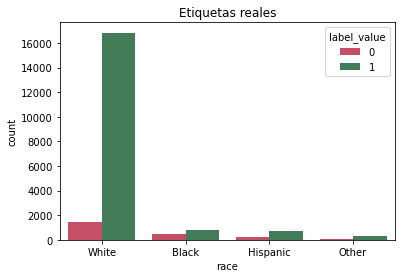

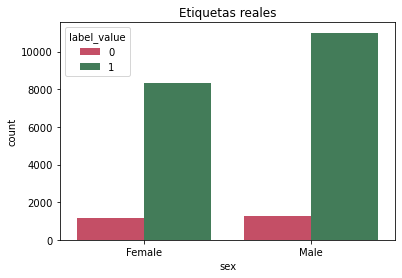

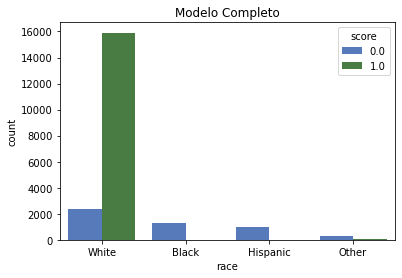

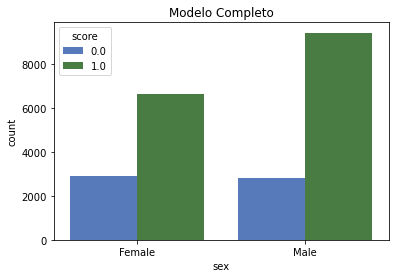

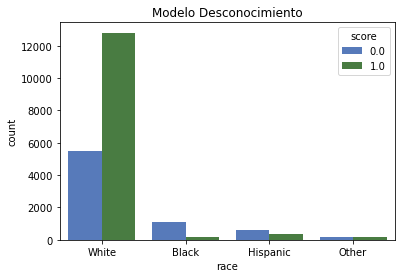

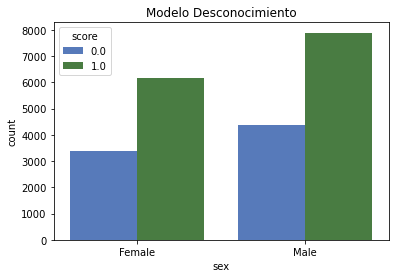

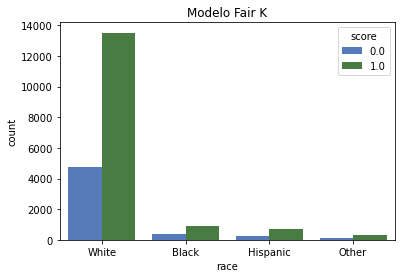

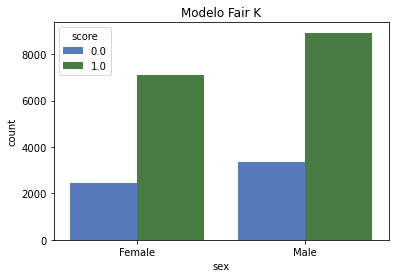

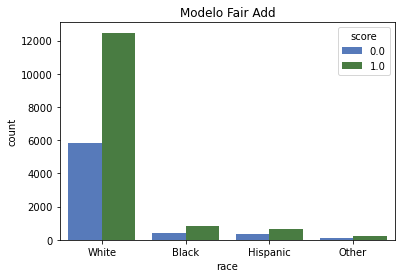

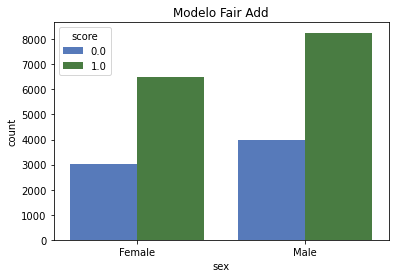

In [25]:
    # Guardamos las gráficas de distribución del score para los diferentes conjuntos
    print_graficas(dataset_full, "label", aq_palette_label, "label_value", "Etiquetas reales")
    print_graficas(dataset_full, "score_full", aq_palette_score, "score", "Modelo Completo")
    print_graficas(dataset_unaware, "score_unaware", aq_palette_score, "score", "Modelo Desconocimiento")
    print_graficas(dataset_fair_k, "score_fair_k", aq_palette_score, "score", "Modelo Fair K")
    print_graficas(dataset_fair_add, "score_fair_add", aq_palette_score, "score", "Modelo Fair Add")

Calculamos la tabla de las métricas de grupo para cada uno de los modelos:

In [26]:
    # Cálculo de las métricas de grupo
    grupo_full = tabla_metrica_grupo(dataset_full)
    grupo_unaware = tabla_metrica_grupo(dataset_unaware)
    grupo_fair_k = tabla_metrica_grupo(dataset_fair_k)
    grupo_fair_add = tabla_metrica_grupo(dataset_fair_add)

INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex
INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex
INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex
INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex


Calculamos las métricas de sesgo para cada modelo. Usaremos como grupo de referencia la raza *White* y el sexo *Male* por ser históricamente considerados como el grupo aventajado, respecto al resto de grupos demográficos. Las métricas de sesgo se calculan a partir de la siguiente fórmula:

\begin{equation*} 
\text{Métrica Grupo }_{G(a_o)} =\frac{\text{Métrica Grupo }{a_o}}{\text{Métrica Grupo }{a_r}}.
\end{equation*}

Donde $a_o$ representa al grupo objetivo y $a_r$ al de referencia, y métrica de grupo corresponde con las presentadas en la tabla anterior.

In [27]:
    # Establecemos los grupos de referencia para los atributos protegidos
    attr_ref = {'race':'White', 'sex':'Male'}
    # Cálculo de las métricas de sesgo
    sesgo_full = tabla_metrica_sesgo(dataset_full, attr_ref)
    sesgo_unaware = tabla_metrica_sesgo(dataset_unaware, attr_ref)
    sesgo_fair_k = tabla_metrica_sesgo(dataset_fair_k, attr_ref)
    sesgo_fair_add = tabla_metrica_sesgo(dataset_fair_add, attr_ref)

INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex
INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex
INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex


get_disparity_predefined_group()
get_disparity_predefined_group()


INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex


get_disparity_predefined_group()
get_disparity_predefined_group()


Finalmente, calculamos la tabla con todas las medidas de equidad que implementa Aequitas considerando si se cumplen o no. La aceptación o denegación del criterio de equidad se realiza en base a la siguiente fórmula:

\begin{equation}
\tau \leq \text{Métrica de sesgo }_{G} \leq \frac{1}{\tau}.
\end{equation}

Usamos $\tau \in (0,1]$ para controlar el rango de valores de disparidad que pueden considerarse justos. Para aplicar la regla del 80\%, simplemente bastaría con tomar $\tau=0.8$. 

In [28]:
    # Cálculo de las medidas de equidad
    equidad_full, fdf_full = tabla_medidas_equidad(dataset_full, attr_ref)
    equidad_unaware, fdf_unaware = tabla_medidas_equidad(dataset_unaware, attr_ref)
    equidad_fair_k, fdf_fair_k = tabla_medidas_equidad(dataset_fair_k, attr_ref)
    equidad_fair_add, fdf_fair_add = tabla_medidas_equidad(dataset_fair_add, attr_ref)

INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex
INFO:root:get_group_value_fairness...
INFO:root:get_group_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex


get_disparity_predefined_group()


INFO:root:get_group_value_fairness...
INFO:root:get_group_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex


get_disparity_predefined_group()


INFO:root:get_group_value_fairness...
INFO:root:get_group_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex


get_disparity_predefined_group()


INFO:root:get_group_value_fairness...
INFO:root:get_group_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness


get_disparity_predefined_group()


Para concluir con este apartado, imprimiremos la información relativa a las métricas de grupo, sesgo y equidad para los cuatro modelos. También lo complementaremos con unas cuantas gráficas para las métricas más importantes que trataremos:

* **Paridad estadística** - Aequitas utiliza la tasa de positivos predichos (PPR).
* **Probabilidades igualadas** - Cumplir simultáneamente las métricas asociadas a las tasas de falsos y verdaderos positivos (FPR y TPR, respectivamente).
* **Tasa de paridad predictiva** - Cumplir simultáneamente los valores positivo y negativo predictivo (PPV y NPV, respectivamente). En Aequitas el PPV viene almacenado por su otro nombre: precision.
* **Paridad tipo II** - Al encontrarnos con un problema de tipo asistencial, podría ser relevante el estudio de esta medida de equidad. Esta medida de equidad se cumple, cuando se aceptan como justas simultáneamente las métricas relativas a la tasa de falsa omisión (FOR) y falsos negativos (FNR).

#### Modelo completo

In [29]:
    print("Tabla métricas de grupo:\n")
    print(grupo_full)
    print("\nTabla métricas de sesgo:\n")
    print(sesgo_full)
    print("\nTabla medidas de equidad:\n")
    print(equidad_full)

Tabla métricas de grupo:

  attribute_name attribute_value   tpr   tnr   for   fdr   fpr   fnr   npv  \
0           race           Asian  0.11  0.99  0.80  0.03  0.01  0.89  0.20   
1           race           Black  0.00  1.00  0.62   NaN  0.00  1.00  0.38   
2           race        Hispanic  0.03  1.00  0.74  0.05  0.00  0.97  0.26   
3           race           Other  0.24  0.99  0.75  0.01  0.01  0.76  0.25   
4           race           White  0.89  0.34  0.79  0.06  0.66  0.11  0.21   
5            sex          Female  0.75  0.66  0.73  0.06  0.34  0.25  0.27   
6            sex            Male  0.81  0.55  0.76  0.06  0.45  0.19  0.24   

   precision   ppr  pprev  prev  
0       0.97  0.00   0.09  0.82  
1        NaN  0.00   0.00  0.62  
2       0.95  0.00   0.02  0.75  
3       0.99  0.00   0.19  0.80  
4       0.94  0.99   0.87  0.92  
5       0.94  0.41   0.70  0.88  
6       0.94  0.59   0.77  0.90  

Tabla métricas de sesgo:

  attribute_name attribute_value  ppr_disparity  p

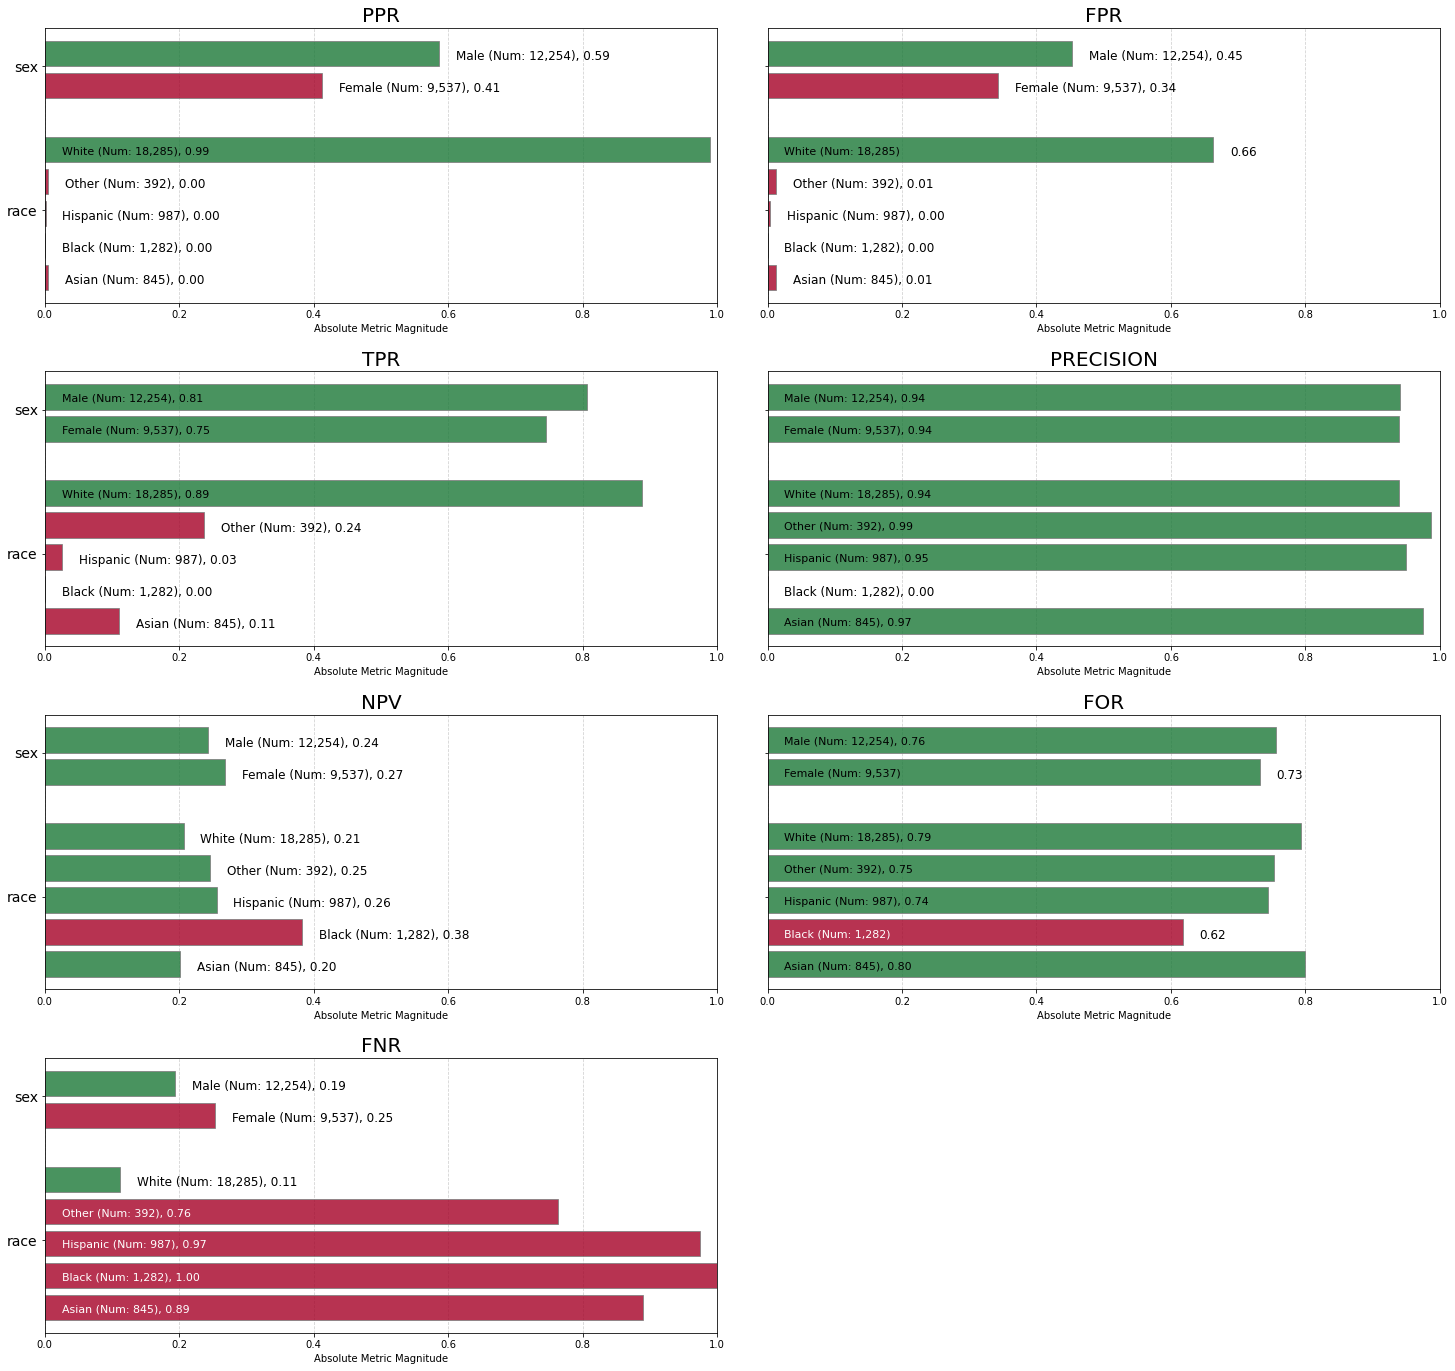

<Figure size 432x288 with 0 Axes>

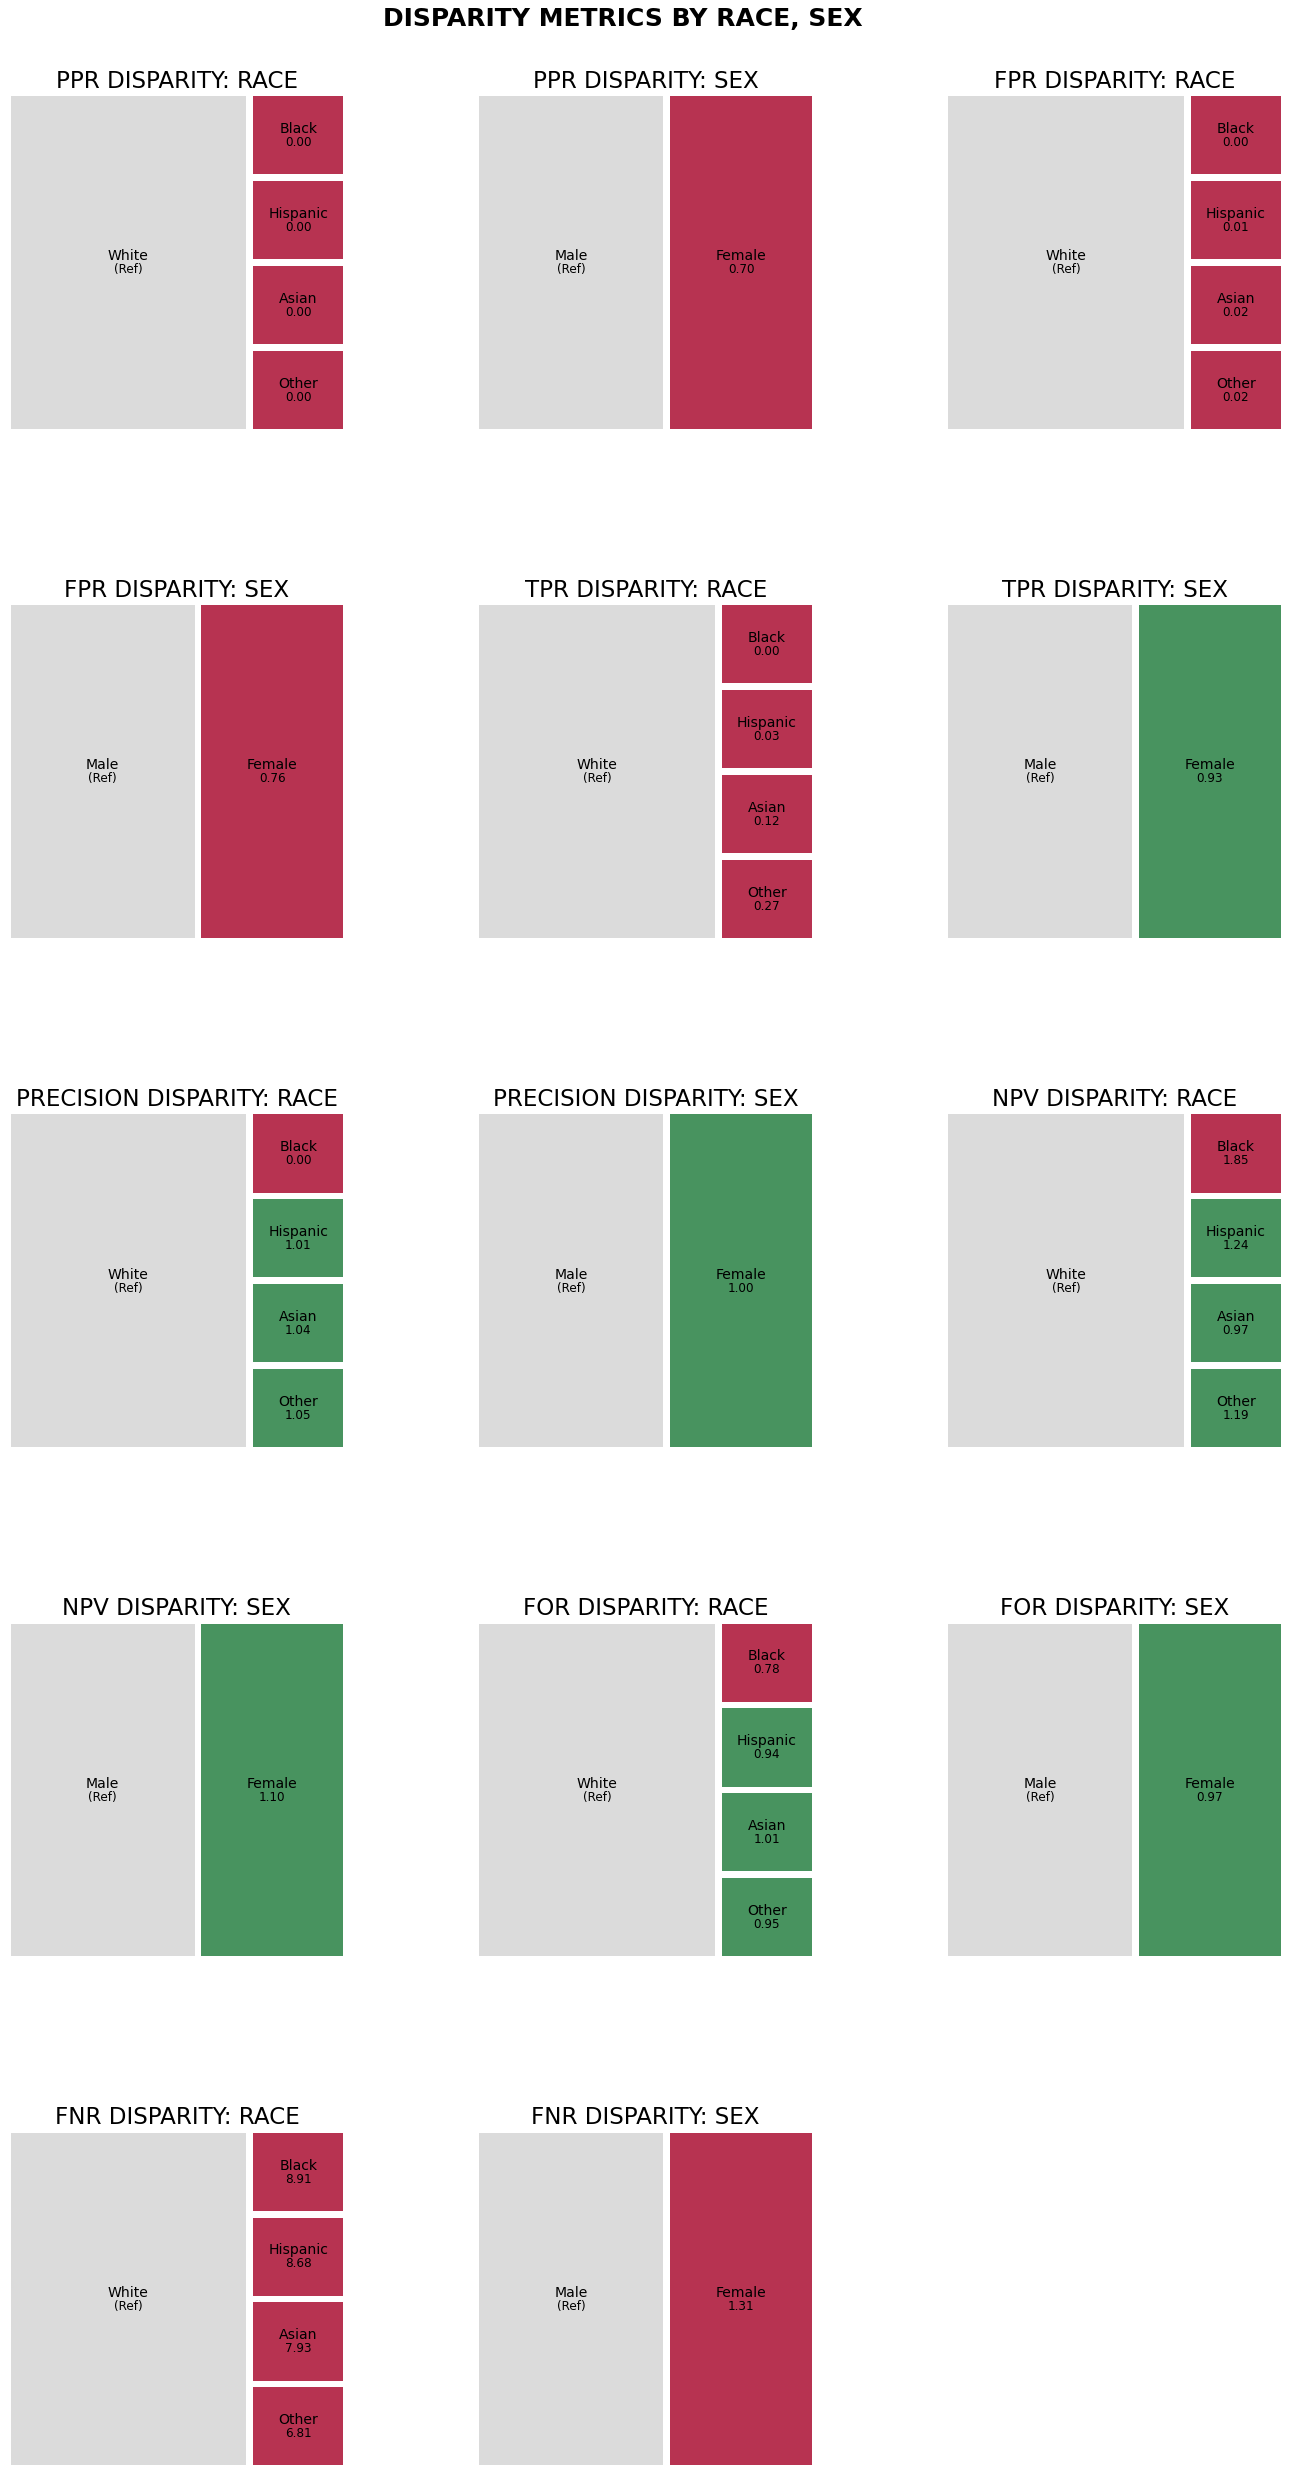

In [30]:
    # Creamos una instancia de la clase Plot() de Aequitas para dibujar gráficas
    aqp = Plot()
    # Mostramos el grafo para las métricas en las que nos vamos a enfocar para el problema
    fg1 = aqp.plot_fairness_group_all(fdf_full, ncols=2, 
                                     metrics = ['ppr', 'fpr', 'tpr', 'precision','npv','for','fnr'])
    m1 = aqp.plot_fairness_disparity_all(fdf_full, metrics=['ppr', 'fpr', 'tpr', 'precision','npv','for','fnr'], 
                                    attributes=['race','sex'])

#### Modelo por desconocimiento

In [31]:
    print("Tabla métricas de grupo:\n")
    print(grupo_unaware)
    print("\nTabla métricas de sesgo:\n")
    print(sesgo_unaware)
    print("\nTabla medidas de equidad:\n")
    print(equidad_unaware)

Tabla métricas de grupo:

  attribute_name attribute_value   tpr   tnr   for   fdr   fpr   fnr   npv  \
0           race           Asian  0.63  0.65  0.71  0.11  0.35  0.37  0.29   
1           race           Black  0.19  0.96  0.58  0.11  0.04  0.81  0.42   
2           race        Hispanic  0.45  0.84  0.66  0.11  0.16  0.55  0.34   
3           race           Other  0.58  0.77  0.68  0.09  0.23  0.42  0.32   
4           race           White  0.72  0.57  0.85  0.05  0.43  0.28  0.15   
5            sex          Female  0.70  0.72  0.75  0.05  0.28  0.30  0.25   
6            sex            Male  0.68  0.66  0.81  0.05  0.34  0.32  0.19   

   precision   ppr  pprev  prev  
0       0.89  0.03   0.58  0.82  
1       0.89  0.01   0.13  0.62  
2       0.89  0.03   0.37  0.75  
3       0.91  0.01   0.51  0.80  
4       0.95  0.91   0.70  0.92  
5       0.95  0.44   0.64  0.88  
6       0.95  0.56   0.64  0.90  

Tabla métricas de sesgo:

  attribute_name attribute_value  ppr_disparity  p

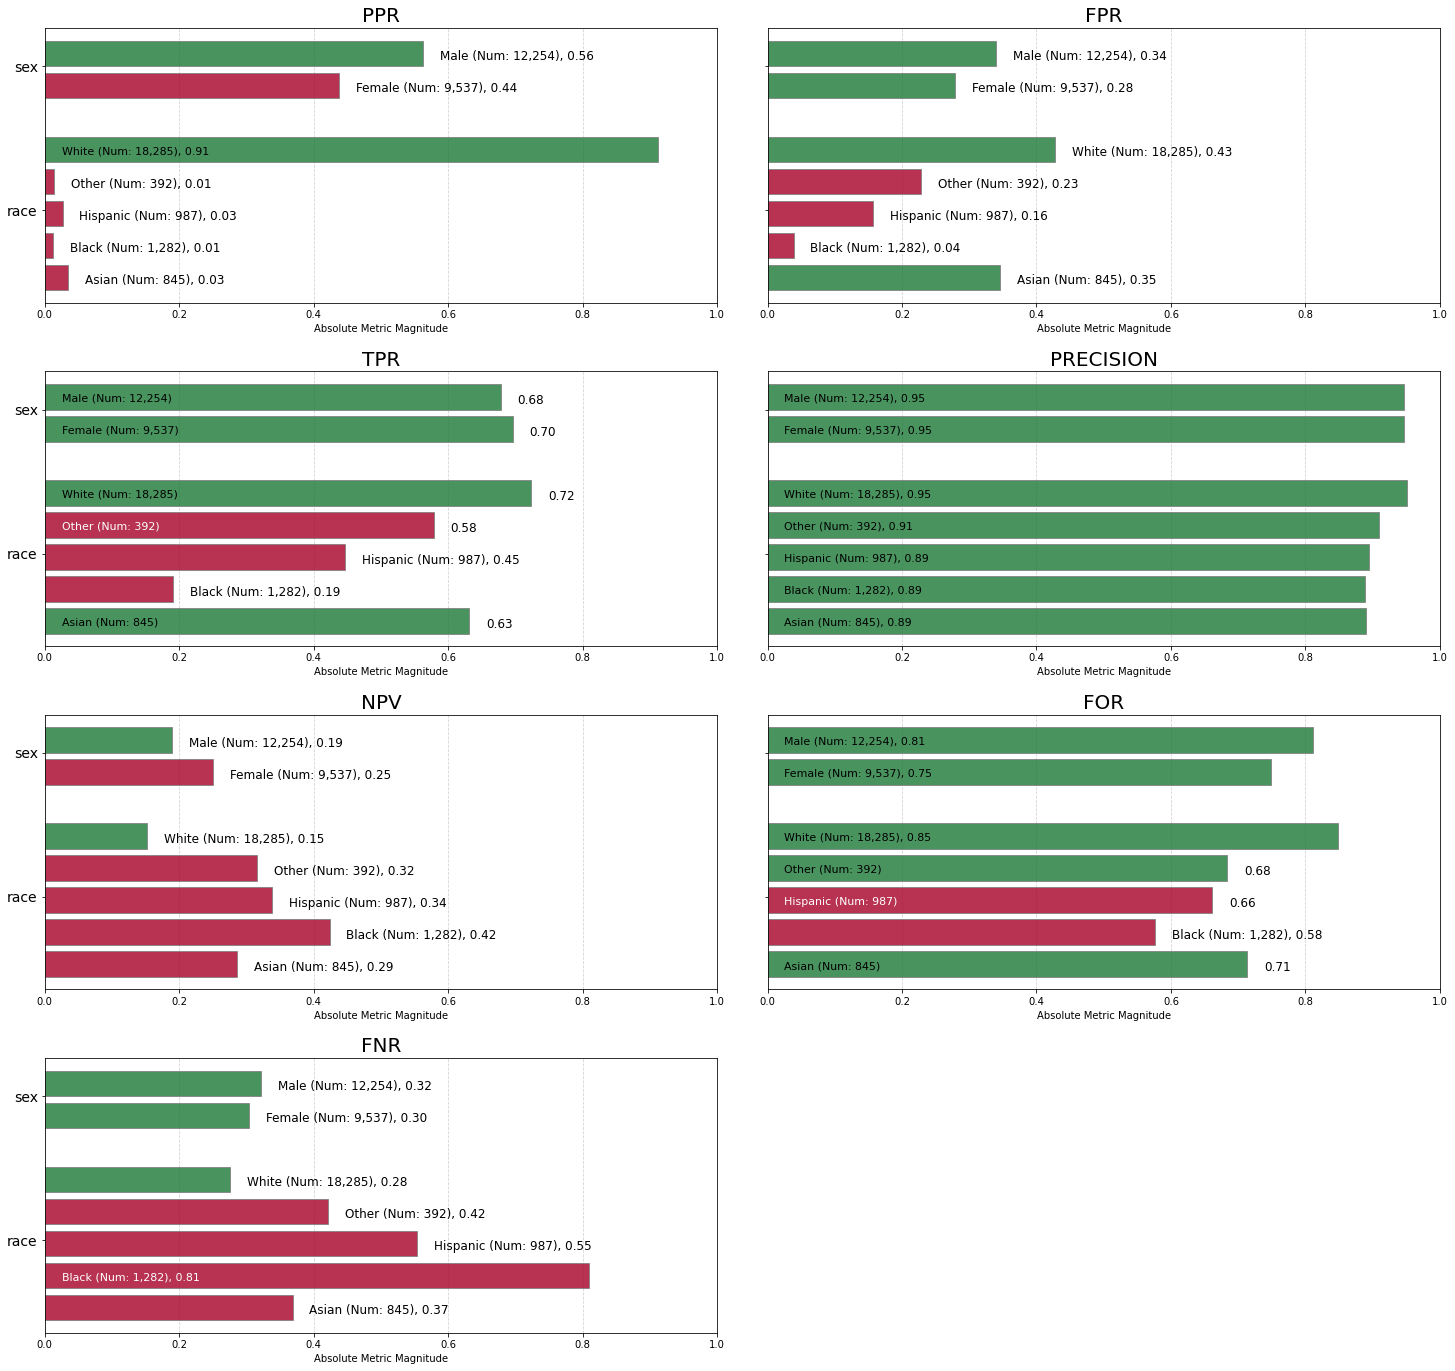

<Figure size 432x288 with 0 Axes>

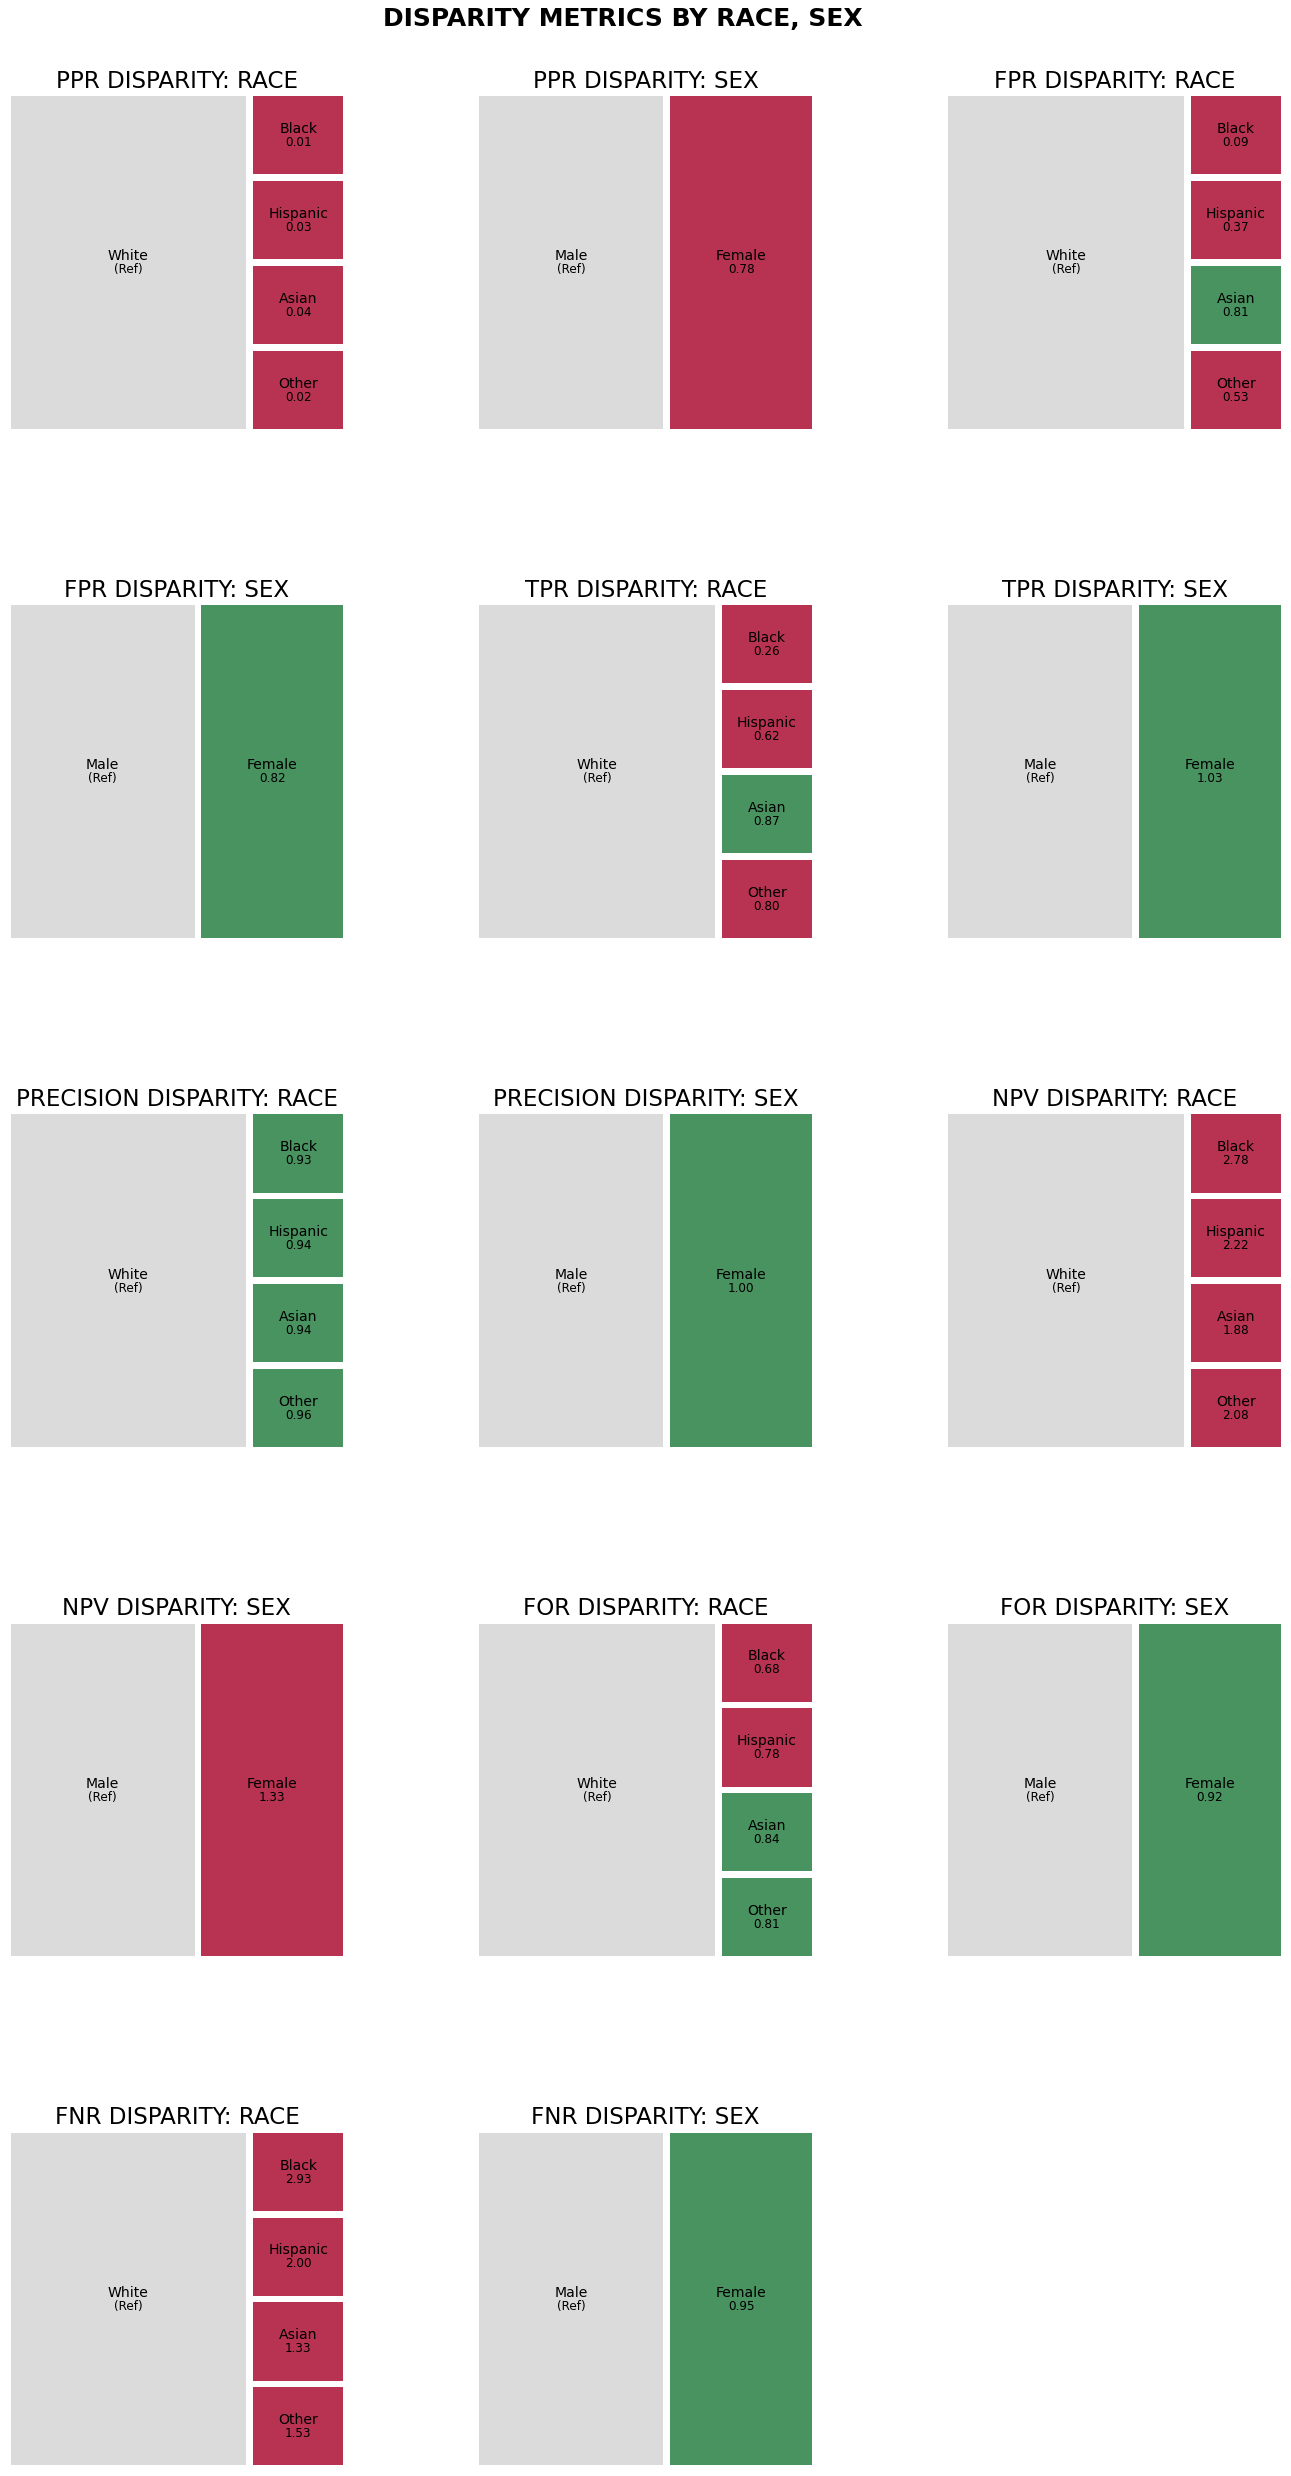

In [32]:
    # Mostramos el grafo para las métricas en las que nos vamos a enfocar para el problema
    fg2 = aqp.plot_fairness_group_all(fdf_unaware, ncols=2, 
                                     metrics = ['ppr', 'fpr', 'tpr', 'precision','npv','for','fnr'])
    m2 = aqp.plot_fairness_disparity_all(fdf_unaware, metrics=['ppr', 'fpr', 'tpr', 'precision','npv','for','fnr'], 
                                    attributes=['race','sex'])

#### Modelo de variable latente (*Fair K*)

In [33]:
    print("Tabla métricas de grupo:\n")
    print(grupo_fair_k)
    print("\nTabla métricas de sesgo:\n")
    print(sesgo_fair_k)
    print("\nTabla medidas de equidad:\n")
    print(equidad_fair_k)

Tabla métricas de grupo:

  attribute_name attribute_value   tpr   tnr   for   fdr   fpr   fnr   npv  \
0           race           Asian  0.74  0.46  0.71  0.14  0.54  0.26  0.29   
1           race           Black  0.74  0.38  0.52  0.34  0.62  0.26  0.48   
2           race        Hispanic  0.76  0.36  0.67  0.22  0.64  0.24  0.33   
3           race           Other  0.78  0.54  0.61  0.13  0.46  0.22  0.39   
4           race           White  0.76  0.44  0.86  0.06  0.56  0.24  0.14   
5            sex          Female  0.77  0.43  0.79  0.09  0.57  0.23  0.21   
6            sex            Male  0.75  0.42  0.84  0.08  0.58  0.25  0.16   

   precision   ppr  pprev  prev  
0       0.86  0.04   0.71  0.82  
1       0.66  0.06   0.69  0.62  
2       0.78  0.04   0.73  0.75  
3       0.87  0.02   0.72  0.80  
4       0.94  0.84   0.74  0.92  
5       0.91  0.44   0.74  0.88  
6       0.92  0.56   0.73  0.90  

Tabla métricas de sesgo:

  attribute_name attribute_value  ppr_disparity  p

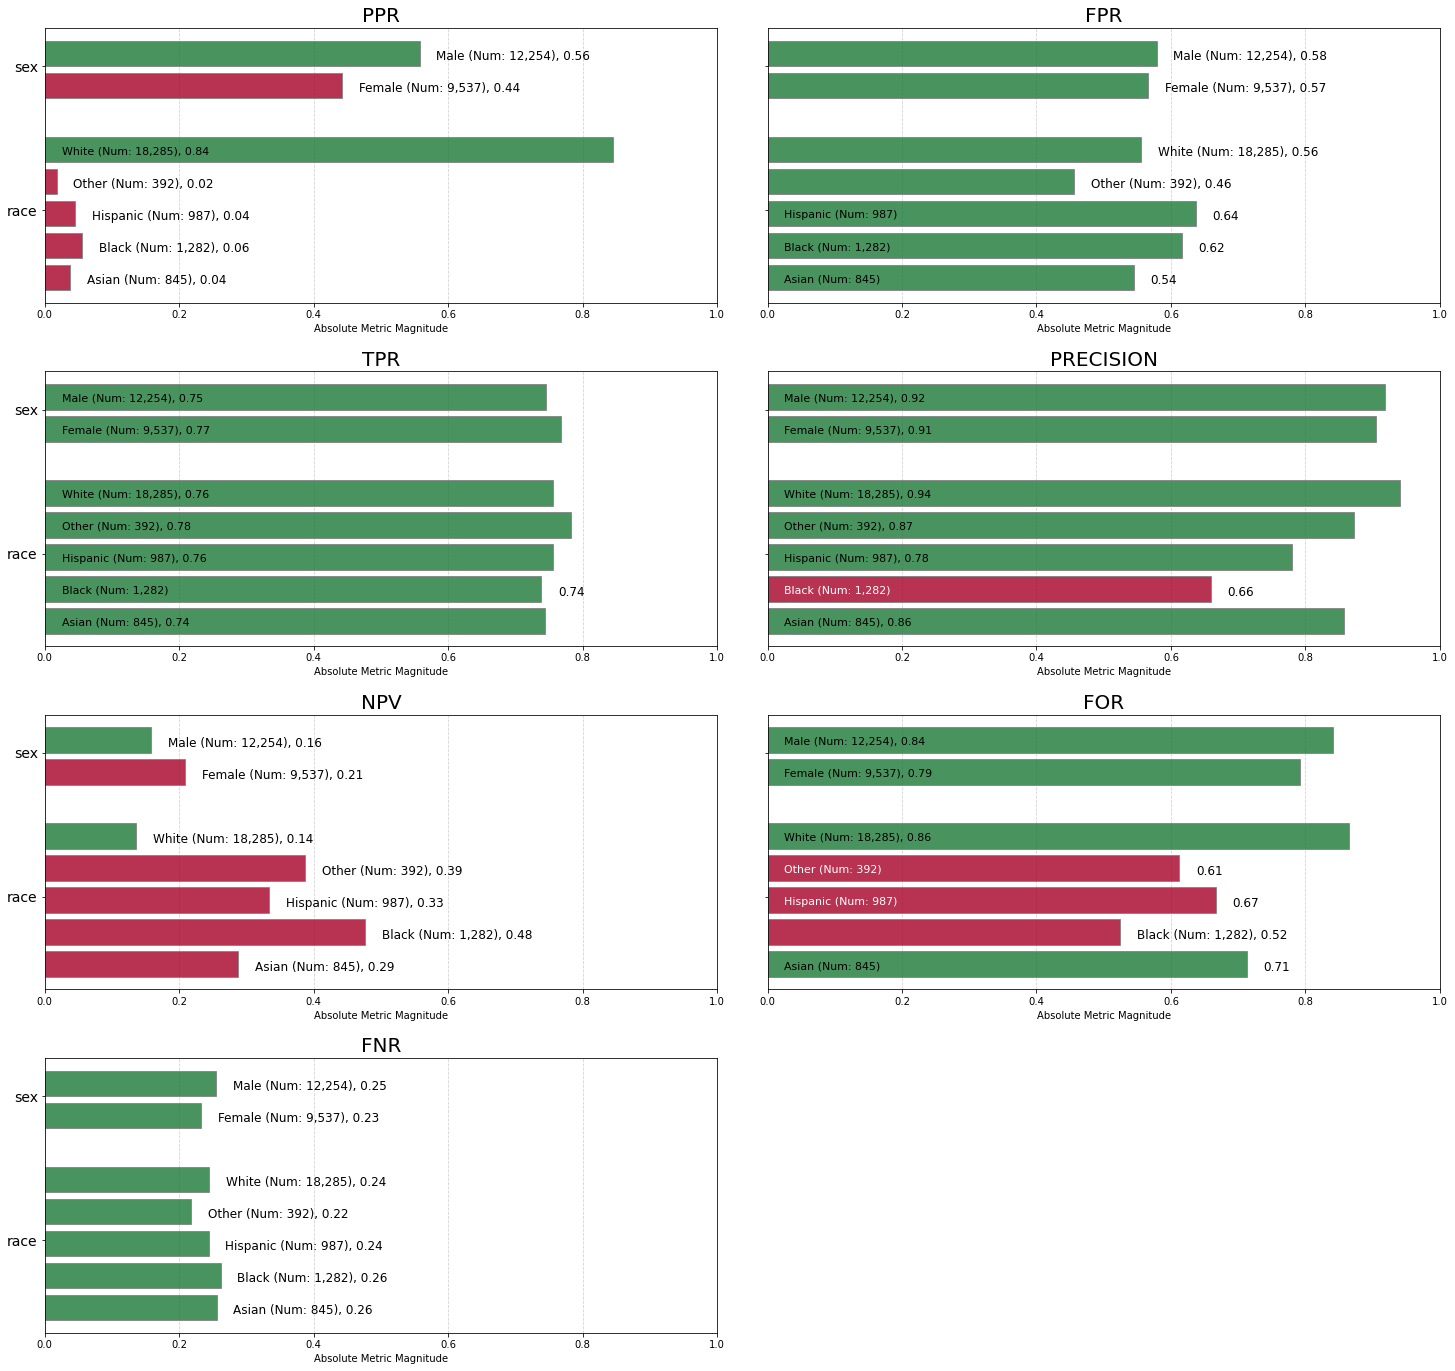

<Figure size 432x288 with 0 Axes>

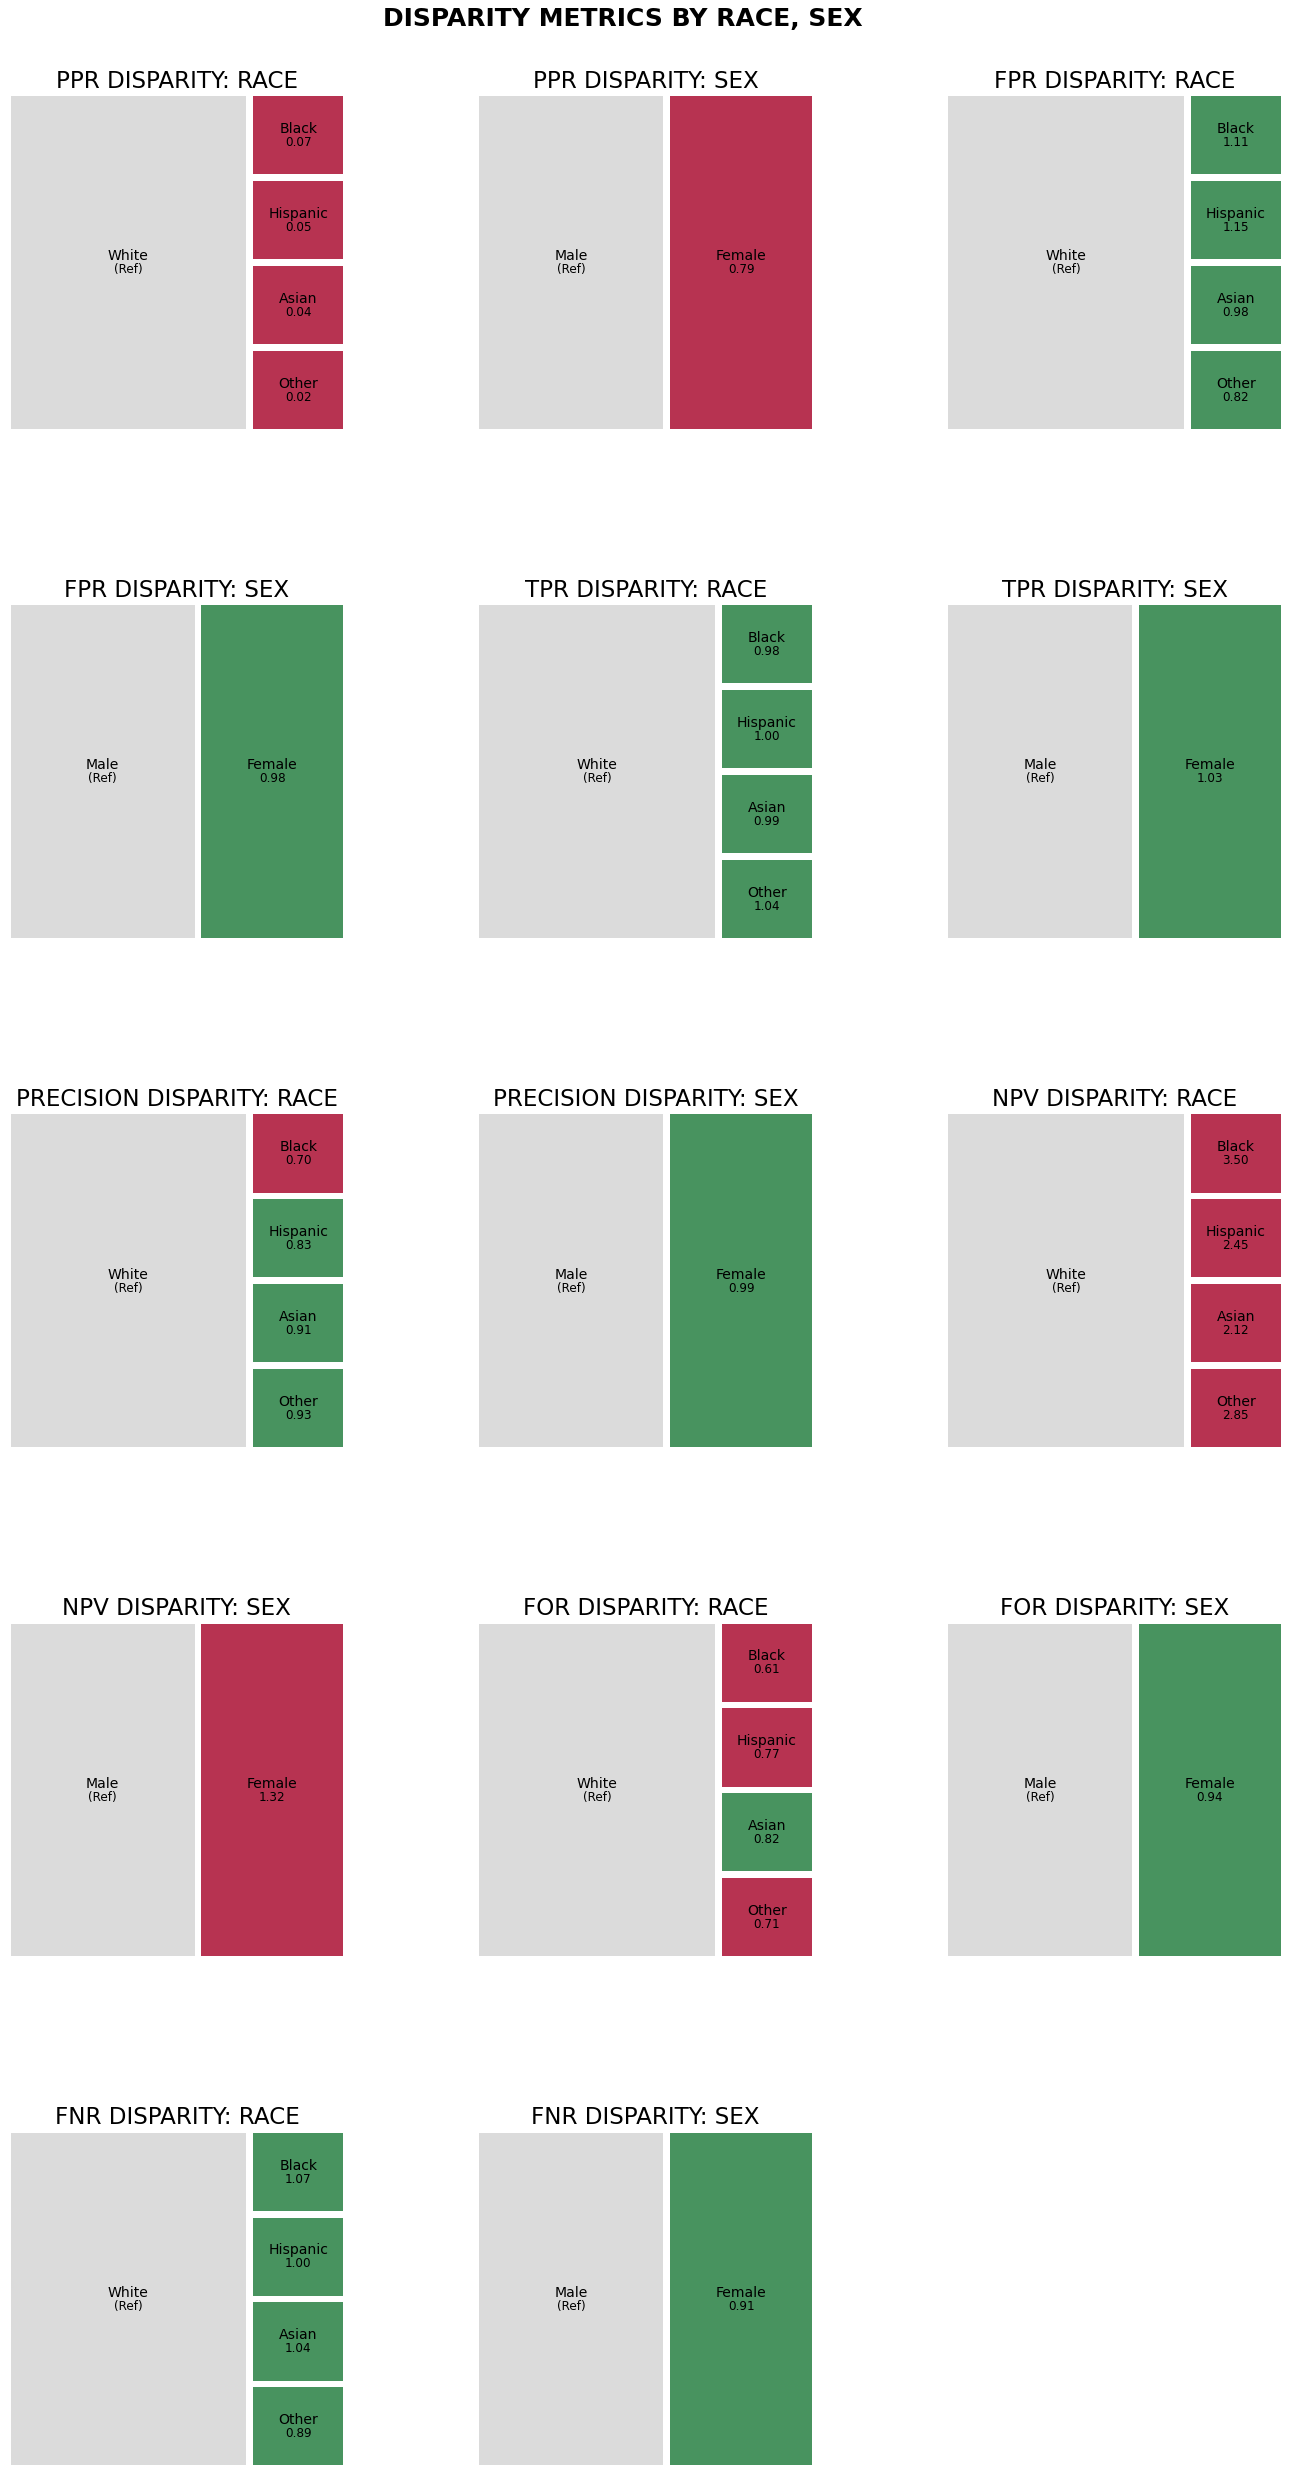

In [34]:
    # Mostramos el grafo para las métricas en las que nos vamos a enfocar para el problema
    fg3 = aqp.plot_fairness_group_all(fdf_fair_k, ncols=2, 
                                     metrics = ['ppr', 'fpr', 'tpr', 'precision','npv','for','fnr'])
    m3 = aqp.plot_fairness_disparity_all(fdf_fair_k, metrics=['ppr', 'fpr', 'tpr', 'precision','npv','for','fnr'], 
                                    attributes=['race','sex'])

#### Modelo de error aditivo (*Fair Add*)

In [35]:
    print("Tabla métricas de grupo:\n")
    print(grupo_fair_add)
    print("\nTabla métricas de sesgo:\n")
    print(sesgo_fair_add)
    print("\nTabla medidas de equidad:\n")
    print(equidad_fair_add)

Tabla métricas de grupo:

  attribute_name attribute_value   tpr   tnr   for   fdr   fpr   fnr   npv  \
0           race           Asian  0.68  0.62  0.70  0.11  0.38  0.32  0.30   
1           race           Black  0.77  0.50  0.42  0.29  0.50  0.23  0.58   
2           race        Hispanic  0.73  0.56  0.58  0.17  0.44  0.27  0.42   
3           race           Other  0.74  0.67  0.60  0.10  0.33  0.26  0.40   
4           race           White  0.71  0.60  0.85  0.05  0.40  0.29  0.15   
5            sex          Female  0.72  0.60  0.77  0.07  0.40  0.28  0.23   
6            sex            Male  0.70  0.55  0.83  0.07  0.45  0.30  0.17   

   precision   ppr  pprev  prev  
0       0.89  0.04   0.62  0.82  
1       0.71  0.06   0.67  0.62  
2       0.83  0.04   0.66  0.75  
3       0.90  0.02   0.66  0.80  
4       0.95  0.84   0.68  0.92  
5       0.93  0.44   0.68  0.88  
6       0.93  0.56   0.67  0.90  

Tabla métricas de sesgo:

  attribute_name attribute_value  ppr_disparity  p

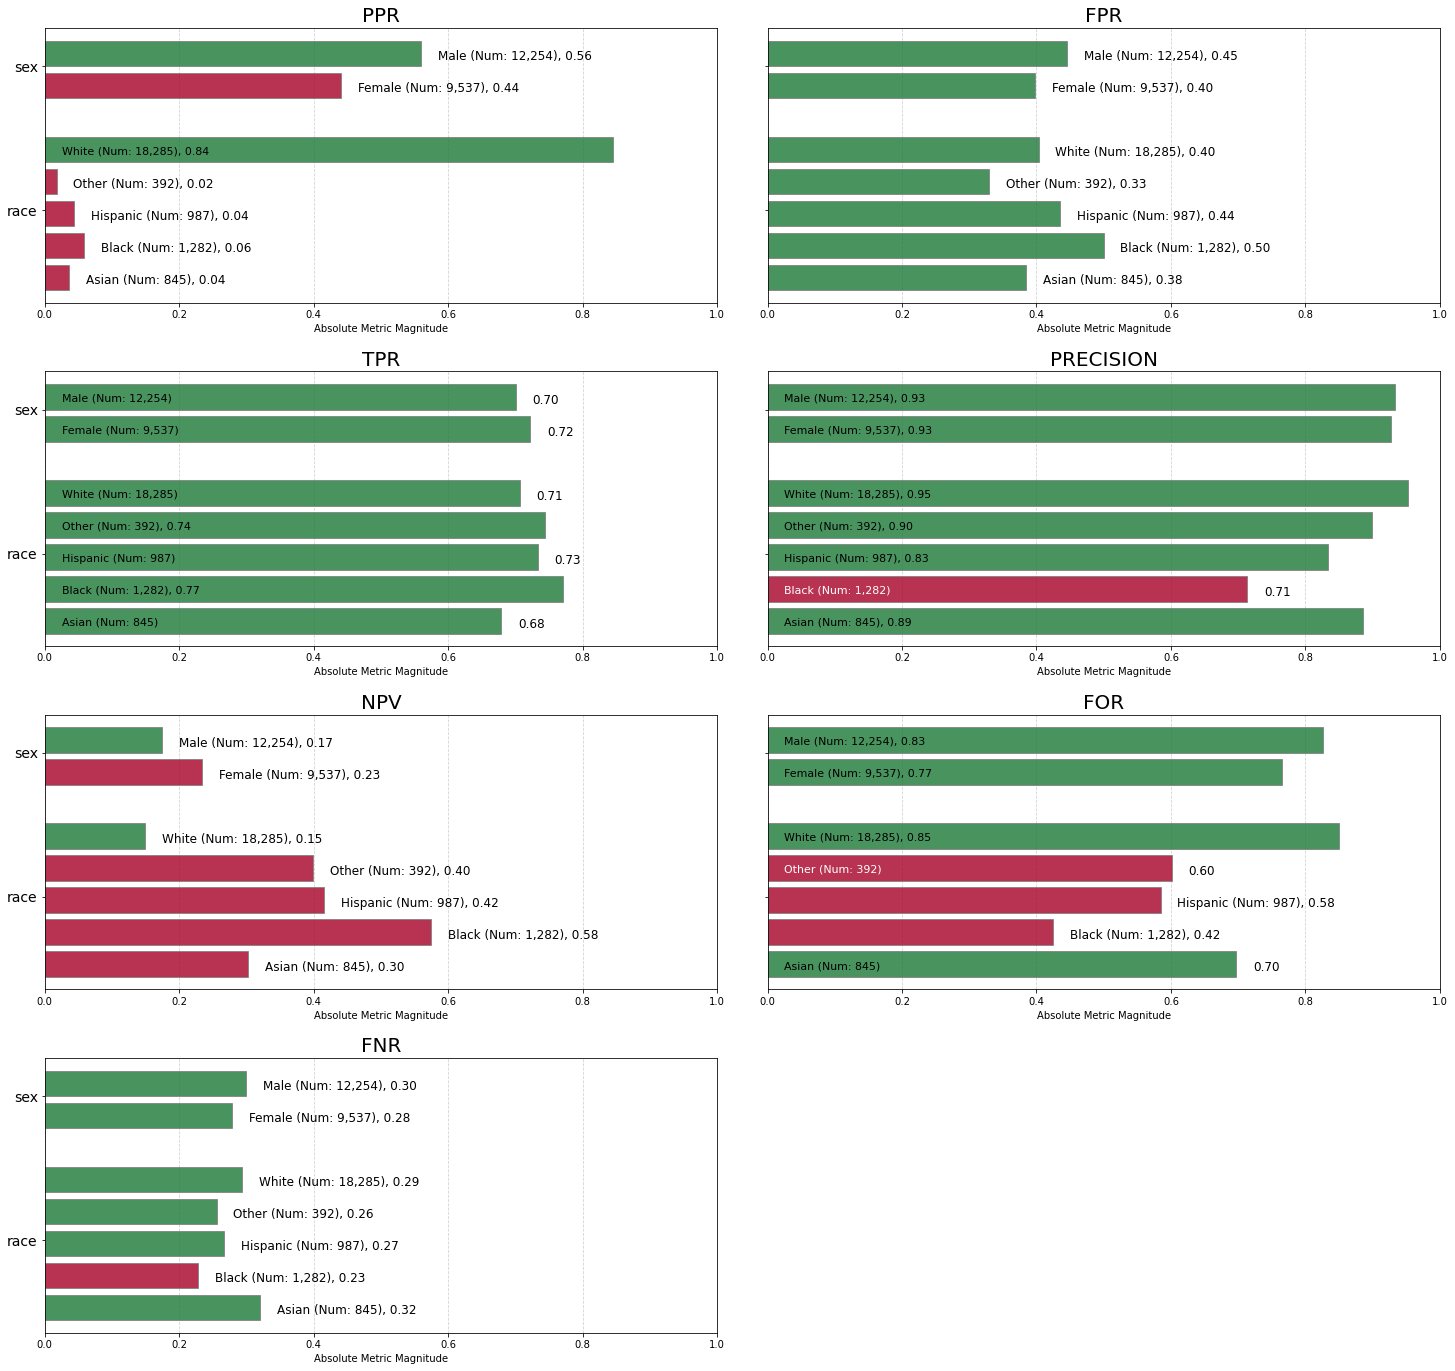

<Figure size 432x288 with 0 Axes>

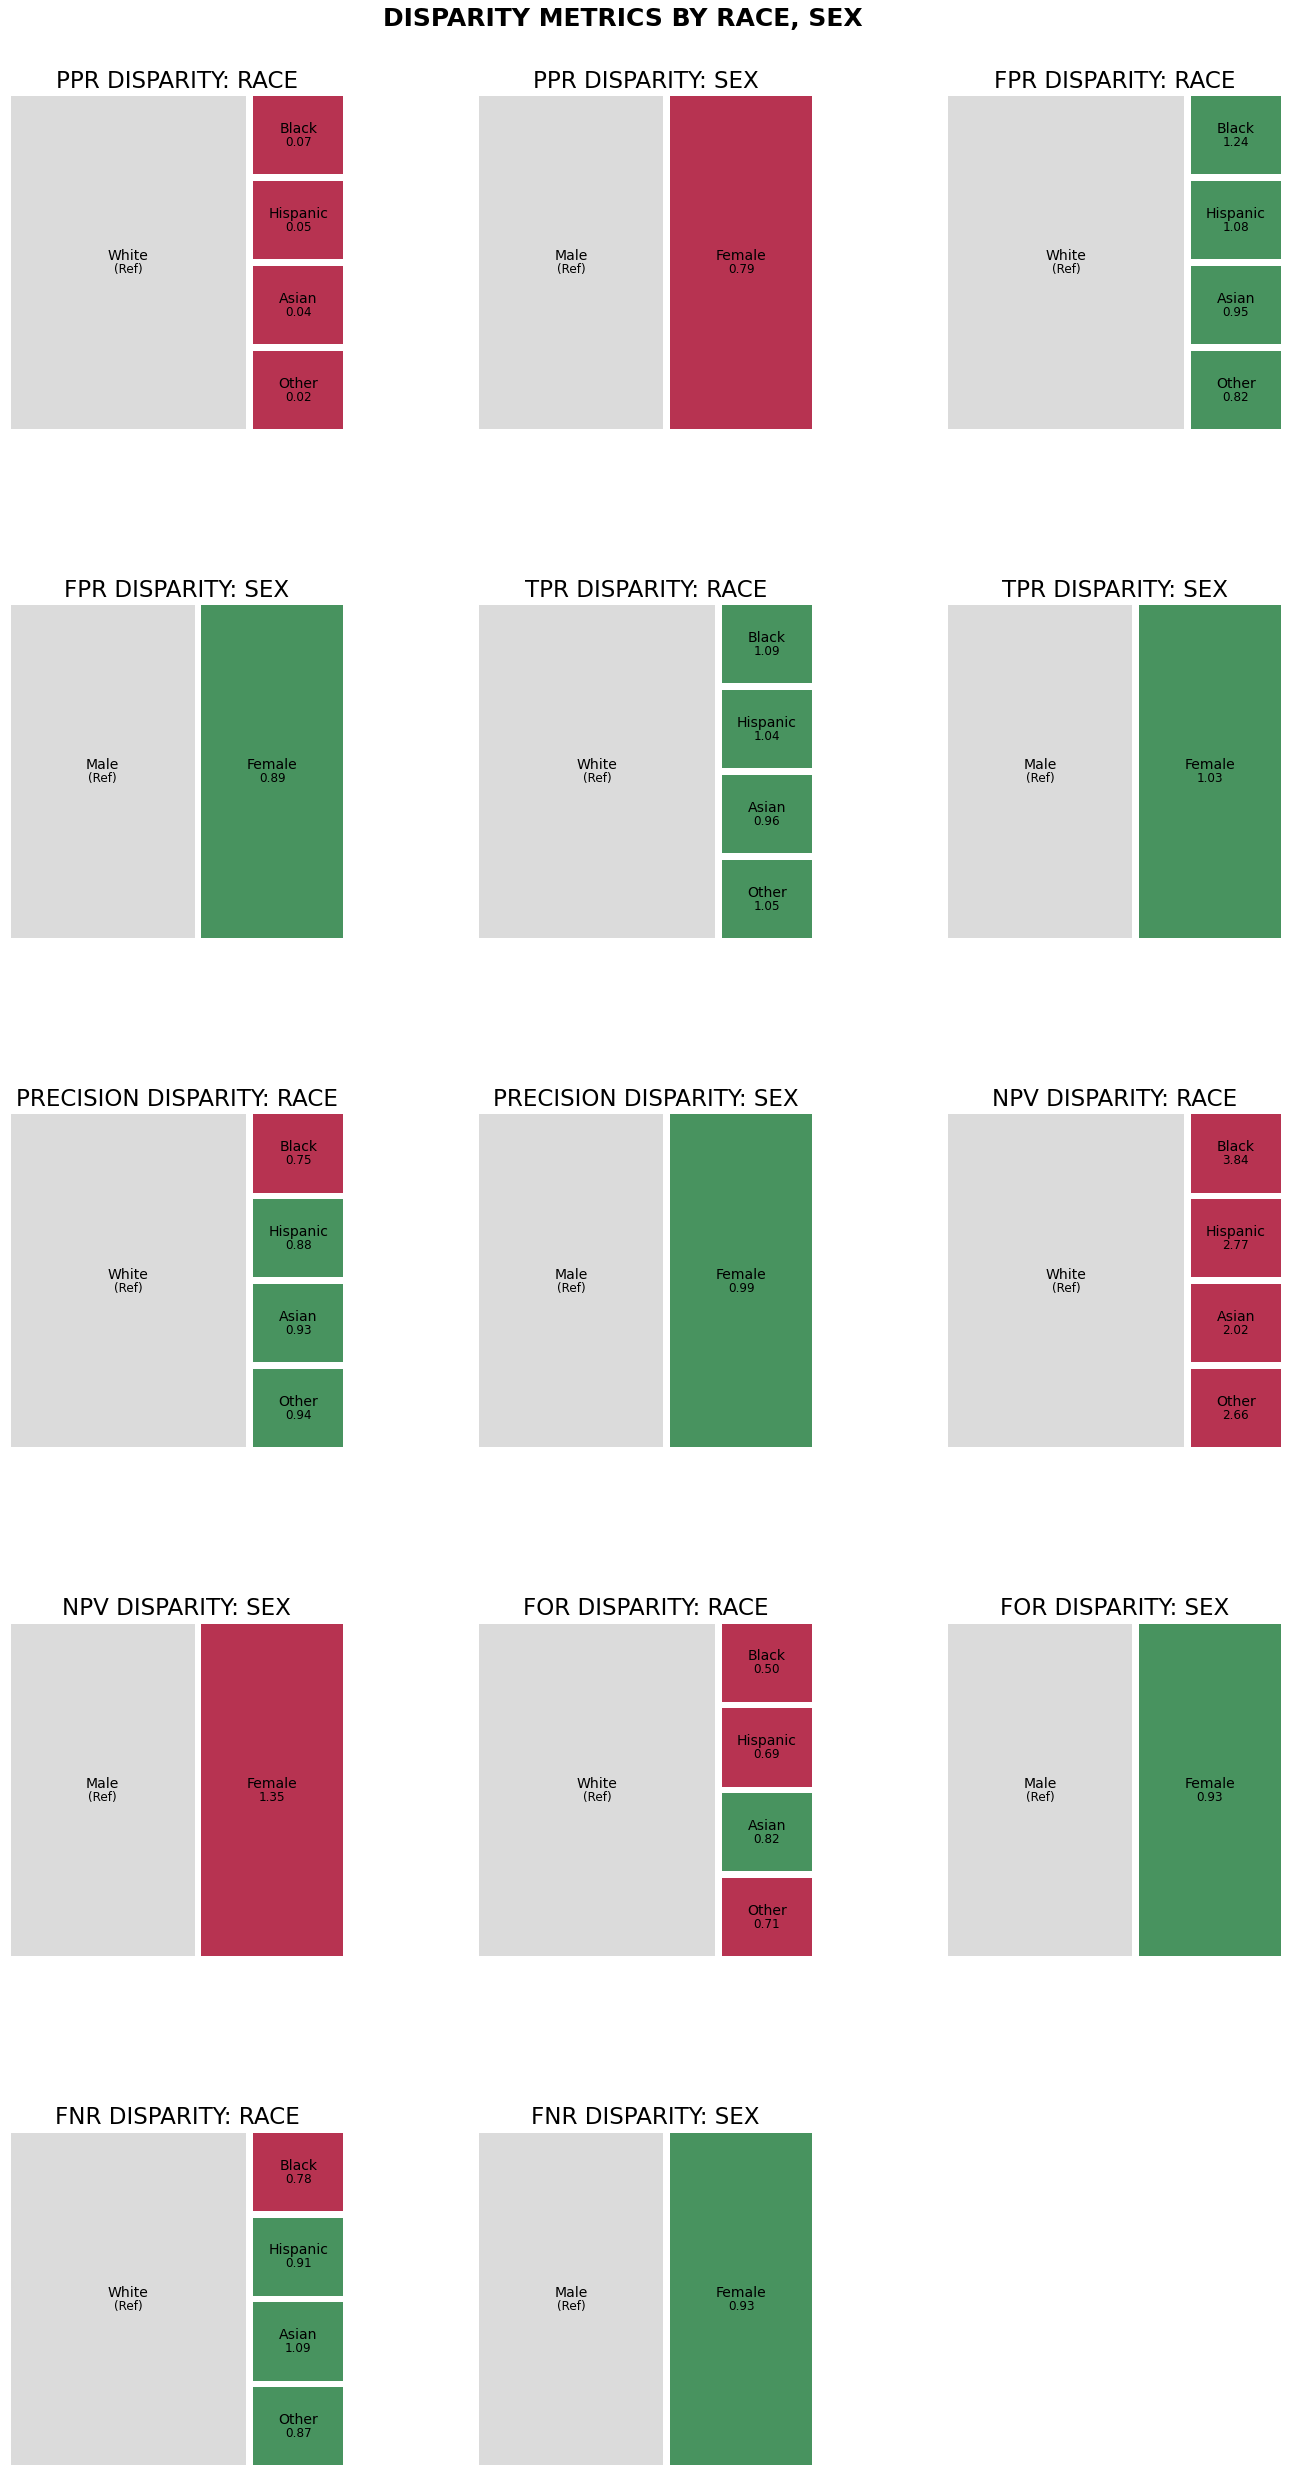

In [36]:
    # Mostramos el grafo para las métricas en las que nos vamos a enfocar para el problema
    fg4 = aqp.plot_fairness_group_all(fdf_fair_add, ncols=2, 
                                     metrics = ['ppr', 'fpr', 'tpr', 'precision','npv','for','fnr'])
    m4 = aqp.plot_fairness_disparity_all(fdf_fair_add, metrics=['ppr', 'fpr', 'tpr', 'precision','npv',
                                                                'for','fnr'], attributes=['race','sex'])

## Usando Aequitas sobre diferentes *datasets*

Mostraremos dos ejemplos de uso de Aequitas haciendo uso de las diferentes alternativas que ofrece para auditar un *dataset*. Haremos uso de la API de Python que incluye un mayor número de métricas y gráficas para interpretar los resultados.

### Puntuación del riesgo de reincidencia delictiva (COMPAS)

**Descripción de los datos**: Los datos están basados en las estadísticas recogidas en el condado de Broward y puestas a disposición del público por la organización ProPublica. Este conjunto de datos contiene una puntuación del riesgo de reincidencia para 7.214 individuos, sus resultados reales de reincidencia a los dos años y una serie de atributos recogidos entre 2013 y 2014. Para tratar la puntuación de riesgo con Aequitas, convertiremos el *score* original (1-10) a uno binario donde 0 indica riesgo bajo y 1 medio o alto.

1. Primero cargaremos el conjunto de los datos y mostraremos la distribución de sus puntuaciones (*score*):

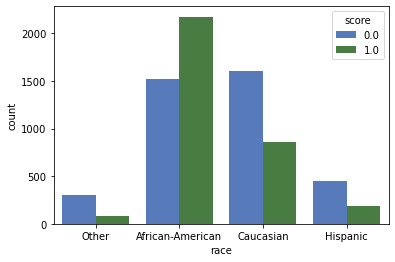

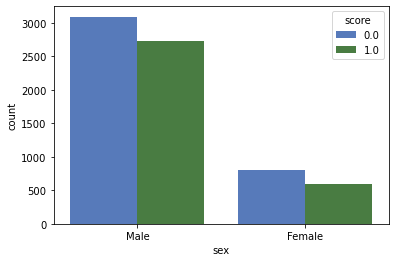

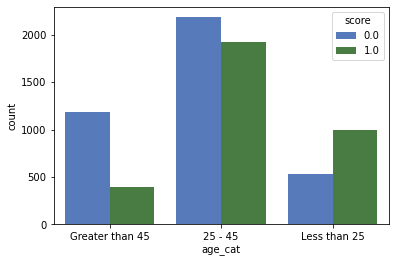

In [37]:
    # Cargamos el conjunto de datos
    dataset_compas = pd.read_csv('./datos/compas_for_aequitas.csv', index_col=0)  
    
    # Hacemos un estudio previo de los individuos por score y etiqueta real
    score_race = sns.countplot(x="race", hue="score", 
                data=dataset_compas[dataset_compas.race.isin(['African-American', 'Caucasian', 
                                                              'Hispanic', 'Other'])], palette=aq_palette_score)
    plt.show()
    score_sex = sns.countplot(x="sex", hue="score", data=dataset_compas, palette=aq_palette_score)
    plt.show()
    score_age = sns.countplot(x="age_cat", hue="score", data=dataset_compas, palette=aq_palette_score)
    plt.show()

y sus etiquetas (*label_value*):

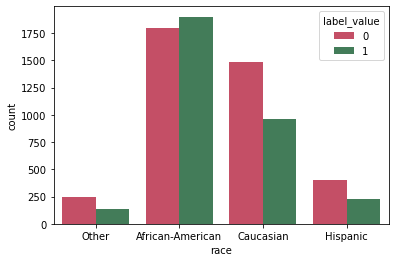

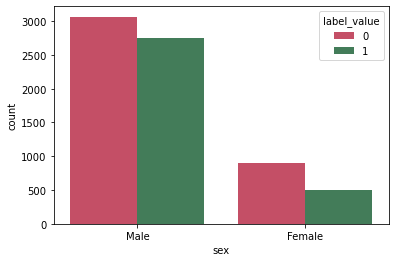

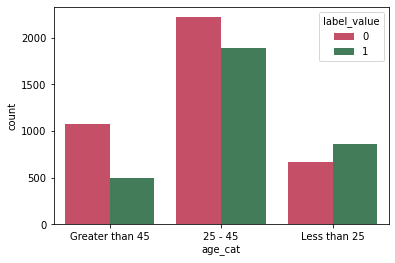

In [38]:
    label_race = sns.countplot(x="race", hue="label_value", 
                data=dataset_compas[dataset_compas.race.isin(['African-American', 'Caucasian', 
                                                              'Hispanic', 'Other'])], palette=aq_palette_label)
    plt.show()
    label_sex = sns.countplot(x="sex", hue="label_value", data=dataset_compas, palette=aq_palette_label)
    plt.show()
    label_sex = sns.countplot(x="age_cat", hue="label_value", data=dataset_compas, palette=aq_palette_label)
    plt.show()

2. Calcularemos el valor de las métricas de grupo, en su formato tabla:

In [39]:
    g = Group()
    xtab, _ = g.get_crosstabs(dataset_compas)
    absolute_metrics = g.list_absolute_metrics(xtab)
    # Mostramos la tabla por pantalla
    tabla_grupo_compas = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)
    print(tabla_grupo_compas)

INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex,age_cat


   attribute_name   attribute_value   tpr   tnr   for   fdr   fpr   fnr   npv  \
0            race  African-American  0.72  0.55  0.35  0.37  0.45  0.28  0.65   
1            race             Asian  0.67  0.91  0.12  0.25  0.09  0.33  0.88   
2            race         Caucasian  0.52  0.77  0.29  0.41  0.23  0.48  0.71   
3            race          Hispanic  0.44  0.79  0.29  0.46  0.21  0.56  0.71   
4            race   Native American  0.90  0.62  0.17  0.25  0.38  0.10  0.83   
5            race             Other  0.32  0.85  0.30  0.46  0.15  0.68  0.70   
6             sex            Female  0.61  0.68  0.24  0.49  0.32  0.39  0.76   
7             sex              Male  0.63  0.68  0.33  0.36  0.32  0.37  0.67   
8         age_cat           25 - 45  0.63  0.67  0.32  0.39  0.33  0.37  0.68   
9         age_cat   Greater than 45  0.43  0.83  0.24  0.46  0.17  0.57  0.76   
10        age_cat      Less than 25  0.74  0.46  0.42  0.36  0.54  0.26  0.58   

    precision   ppr  pprev 

También podemos mostrar un gráfico para una o varias métricas de grupo específicas:

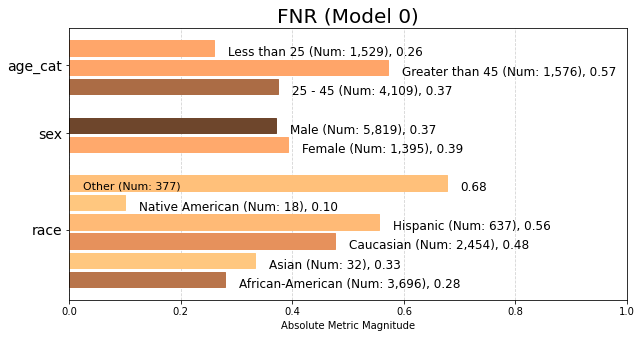

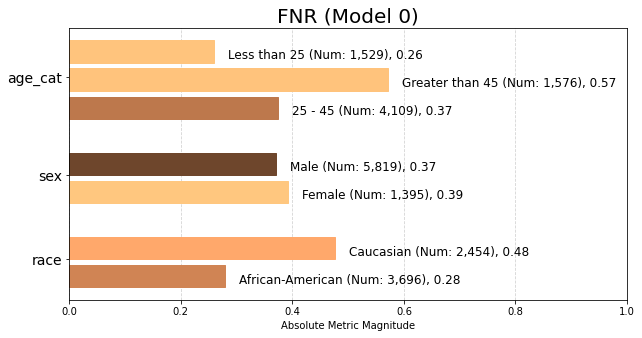

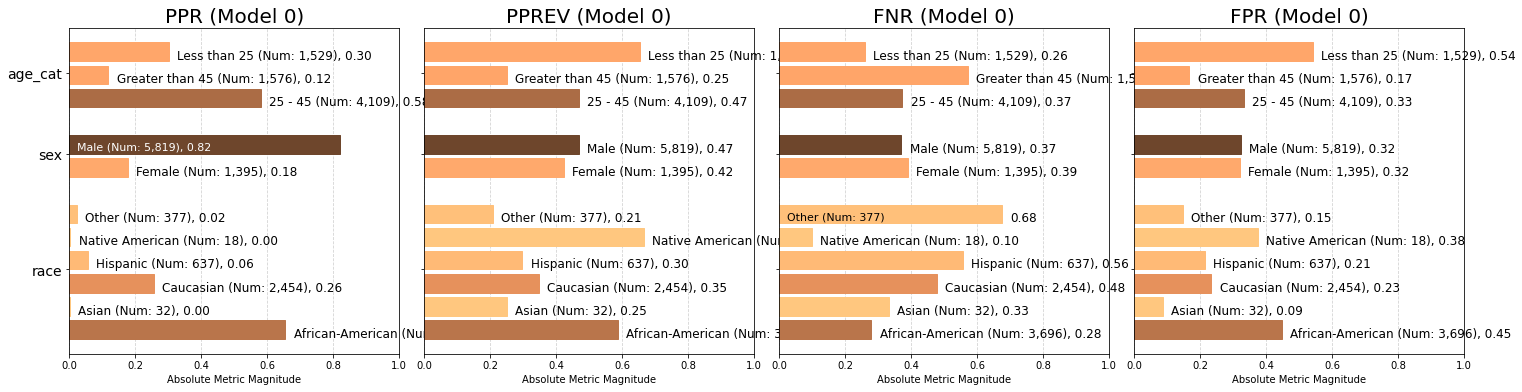

<Figure size 432x288 with 0 Axes>

In [40]:
    # Calculamos diferentes gráficas para el conjunto de datos
    aqp = Plot()
    # Plot de los valores de las metricas de grupo para FNR
    fnr = aqp.plot_group_metric(xtab, 'fnr')
    # Plot de los valores de las metricas de grupo para FNR eliminando poblaciones con umbral de individuos
    fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.05)
    # Metricas de grupo para todas las elegidas
    p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

3. Calculamos la tabla para las métricas de sesgo. Recordemos que la métrica de sesgo se calcula utilizando la siguiente fórmula:

\begin{equation*} 
\text{Métrica Grupo }_{G(a_o)} =\frac{\text{Métrica Grupo }{a_o}}{\text{Métrica Grupo }{a_r}}.
\end{equation*}

Tomaremos como referencia para el atributo raza el valor *Caucasian*, para el atributo sexo el valor *Male* y para la edad el intervalo *25-45*.

In [41]:
    # Calculamos las metricas de sesgo
    b = Bias()
    # Establecemos los atributos de referencia
    bdf = b.get_disparity_predefined_groups(xtab, original_df=dataset_compas, ref_groups_dict={'race':'Caucasian', 
          'sex':'Male', 'age_cat':'25 - 45'}, alpha=0.05, mask_significance=True)
    calculated_disparities = b.list_disparities(bdf)
    disparity_significance = b.list_significance(bdf)
    # Mostramos la tabla de metricas de sesgo
    print(bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance])

get_disparity_predefined_group()
   attribute_name   attribute_value  ppr_disparity  pprev_disparity  \
0            race  African-American       2.545667         1.690224   
1            race             Asian       0.009368         0.718384   
2            race         Caucasian       1.000000         1.000000   
3            race          Hispanic       0.222482         0.857099   
4            race   Native American       0.014052         1.915691   
5            race             Other       0.092506         0.602147   
6             sex            Female       0.216801         0.904348   
7             sex              Male       1.000000         1.000000   
8         age_cat           25 - 45       1.000000         1.000000   
9         age_cat   Greater than 45       0.204782         0.533914   
10        age_cat      Less than 25       0.519231         1.395369   

    precision_disparity  fdr_disparity  for_disparity  fpr_disparity  \
0              1.064904       0.906085    

Podemos obtener gráficas de la disparidad sin tener en cuenta, por ahora, ningún concepto de equidad.
Simplemente, comparando los valores obtenidos en la tabla anterior para los grupos objetivo, sobre el grupo
de referencia. 

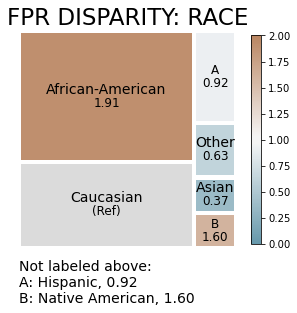

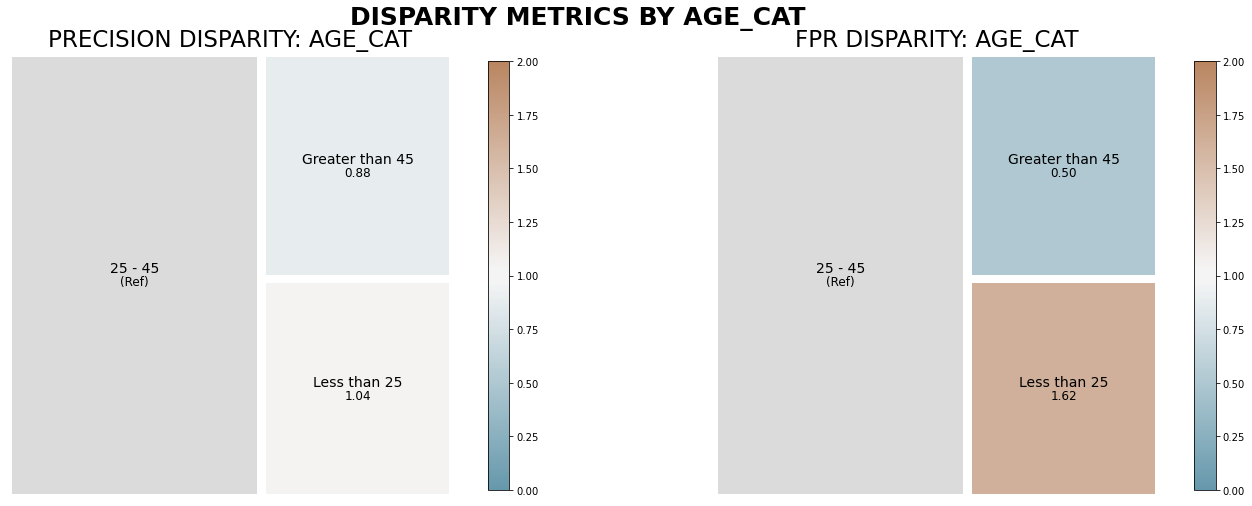

In [42]:
    aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race', significance_alpha=0.05)
    j = aqp.plot_disparity_all(bdf, metrics=['precision_disparity', 'fpr_disparity'], attributes=['age_cat'], 
                               significance_alpha=0.05)

4. Finalmente usamos $\tau=0.8$ para calcular si se cumplen o no los diferentes criterios de justicia implementados en Aequitas. Decidiremos si cumple o no el criterio de justicia basándonos en la ya presentada fórmula:

\begin{equation}
\tau \leq \text{Métrica de sesgo }_{G} \leq \frac{1}{\tau}, \quad \tau \in (0,1].
\end{equation}

In [43]:
    # Definimos las medidas de equidad a partir de la tabla de metricas de sesgo
    f = Fairness()
    # Establecemos el valor del umbral con la variable tau
    fdf = f.get_group_value_fairness(bdf, tau=0.8)
    #parity_detrminations = f.list_parities(fdf)
    # Tabla con si se cumplen las medidas de equidad para cada atributo
    gaf = f.get_group_attribute_fairness(fdf)
    print(gaf)

INFO:root:get_group_value_fairness...
INFO:root:get_group_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness


   model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1        age_cat               False          False   
1         0      binary 0/1           race               False          False   
2         0      binary 0/1            sex               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0        True       False       False       False       False       False   
1       False       False       False       False       False       False   
2       False        True       False        True        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0        True              True         False          False           False   
1        True             False         False          False           False   
2        True              True         False          False            True   

   Unsupervised Fairness  Supervised Fairness

Podemos mostrar las gráficas para las métricas de sesgo, pero esta vez usando los colores verde y rojo indicando si cumplen o no la disparidad para el umbral establecido.

Dado que en el marco del *COMPAS* las predicciones se utilizan para tomar decisiones de liberación previa al juicio, las intervenciones serán punitivas (proporcionar esta intervención a los individuos que son falsos positivos les perjudicará), así que deberemos tener en cuenta las tasas de falsos descubrimientos (FDR) y las tasas de falsos positivos (FPR).

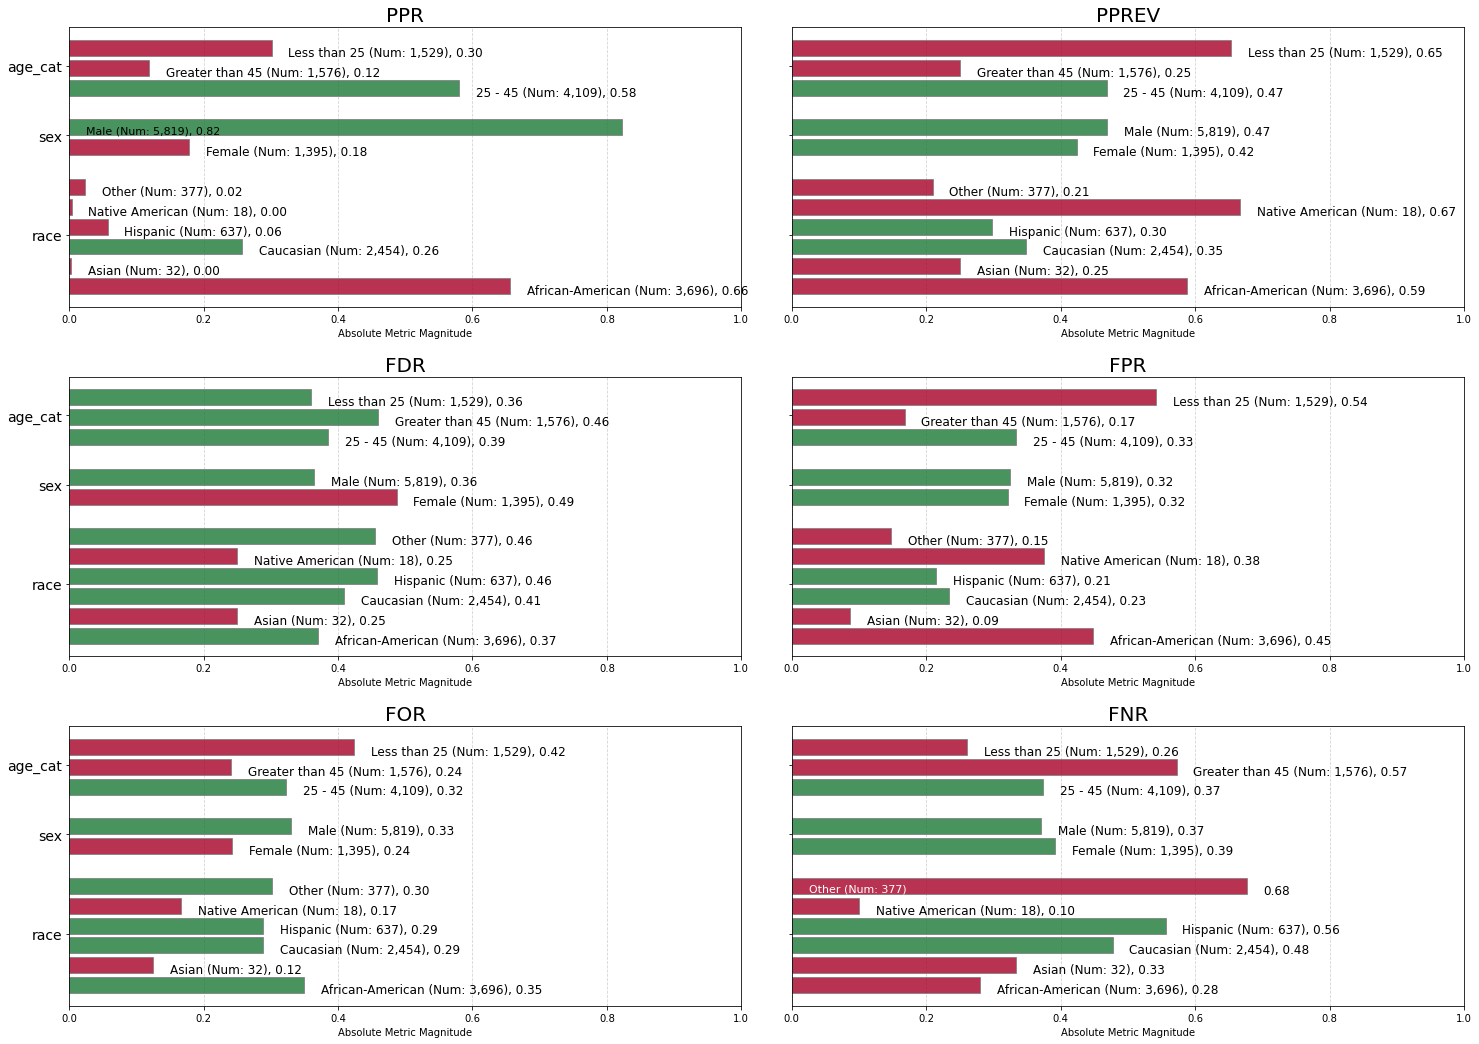

<Figure size 432x288 with 0 Axes>

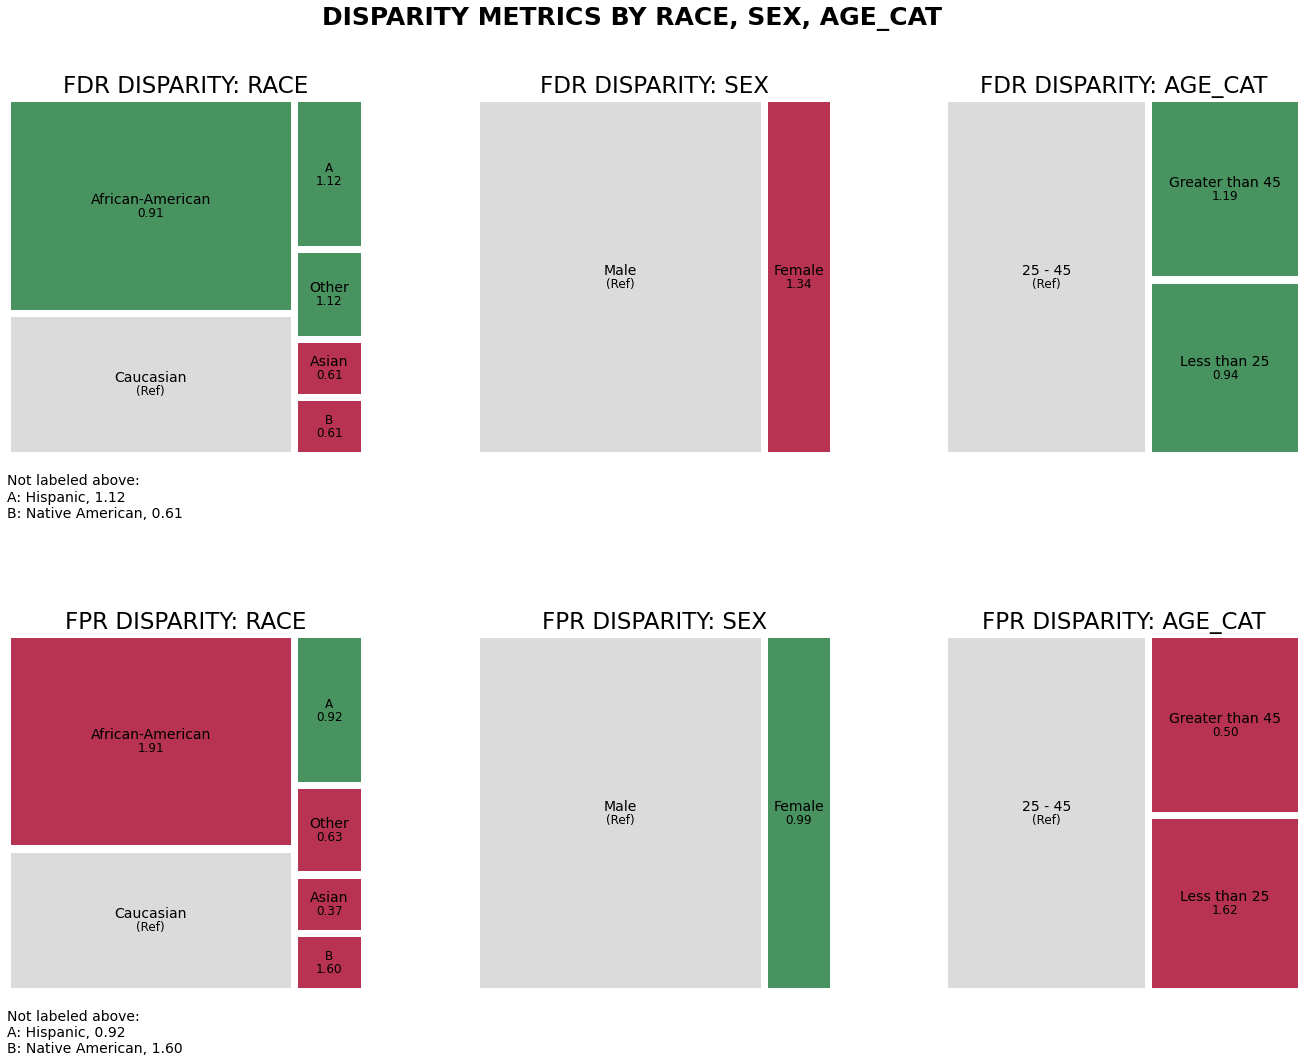

In [44]:
    # Metricas de grupo y de sesgo una vez aplicados los umbrales de equidad
    fg = aqp.plot_fairness_group_all(fdf, ncols=2, metrics = ['ppr','pprev','fdr','fpr','for','fnr'])
    m = aqp.plot_fairness_disparity_all(fdf, metrics=['fdr','fpr'], attributes=['race','sex','age_cat'])

### Predicción de notas en la facultad de derecho (law_data)

**Descripción de los datos**: El Consejo de Admisión de las Facultades de Derecho realizó una encuesta en 163 facultades de Derecho de Estados Unidos. Contiene información sobre 21.790 estudiantes de Derecho, tales como las puntuaciones de su examen de acceso (LSAT), su media del expediente (GPA) antes de entrar en la facultad, y su nota media del primer año (FYA) en la carrera de Derecho. A partir de estos datos, una escuela querría predecir si un solicitante tendrá un FYA alto.

1. Cargamos el conjunto de los datos el cúal hemos preprocesado previamente para adaptarlo a la estructura de Aequitas, y mostraremos la distribución de sus puntuaciones (*score*):

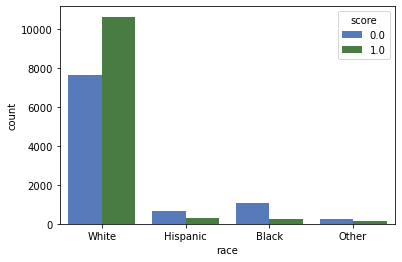

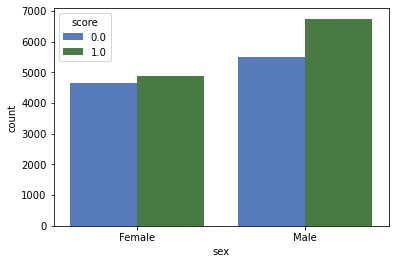

In [45]:
    # Cargamos el conjunto de datos
    dataset_law = pd.read_csv('./datos/law_for_aequitas.csv', index_col=0)  
    
    # Hacemos un estudio previo de los individuos por score y etiqueta real
    aq_palette_score = sns.diverging_palette(255, 125, n=2)
    aq_palette_label = sns.diverging_palette(5, 140, n=2)
    score_race = sns.countplot(x="race", hue="score", 
                data=dataset_law[dataset_law.race.isin(['Black', 'White', 'Hispanic', 'Other'])], 
                palette=aq_palette_score)
    plt.show()
    score_sex = sns.countplot(x="sex", hue="score", data=dataset_law, palette=aq_palette_score)
    plt.show()

y sus etiquetas (*label_value*):

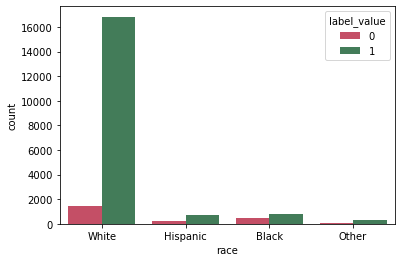

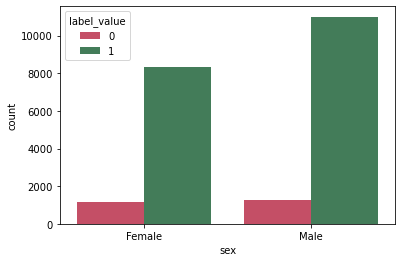

In [46]:
    label_race = sns.countplot(x="race", hue="label_value", 
                data=dataset_law[dataset_law.race.isin(['Black', 'White', 'Hispanic', 'Other'])], 
                palette=aq_palette_label)
    plt.show()
    label_sex = sns.countplot(x="sex", hue="label_value", data=dataset_law, palette=aq_palette_label)
    plt.show()

2. Calcularemos el valor de las métricas de grupo, en su formato tabla:

In [47]:
    g = Group()
    xtab, _ = g.get_crosstabs(dataset_law)
    absolute_metrics = g.list_absolute_metrics(xtab)
    # Mostramos la tabla por pantalla
    tabla_grupo_law = xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)
    print(tabla_grupo_law)

INFO:root:getcrosstabs: attribute columns to perform crosstabs:race,sex


  attribute_name attribute_value   tpr   tnr   for   fdr   fpr   fnr   npv  \
0           race           Asian  0.39  0.90  0.75  0.06  0.10  0.61  0.25   
1           race           Black  0.24  0.93  0.57  0.15  0.07  0.76  0.43   
2           race        Hispanic  0.39  0.90  0.67  0.08  0.10  0.61  0.33   
3           race           Other  0.50  0.95  0.67  0.02  0.05  0.50  0.33   
4           race           White  0.61  0.80  0.85  0.03  0.20  0.39  0.15   
5            sex          Female  0.56  0.86  0.78  0.03  0.14  0.44  0.22   
6            sex            Male  0.59  0.84  0.81  0.03  0.16  0.41  0.19   

   precision   ppr  pprev  prev  
0       0.94  0.02   0.34  0.82  
1       0.85  0.02   0.18  0.62  
2       0.92  0.03   0.32  0.75  
3       0.98  0.01   0.41  0.80  
4       0.97  0.91   0.58  0.92  
5       0.97  0.42   0.51  0.88  
6       0.97  0.58   0.55  0.90  


Mostramos un gráfico para una o varias métricas de grupo específicas:

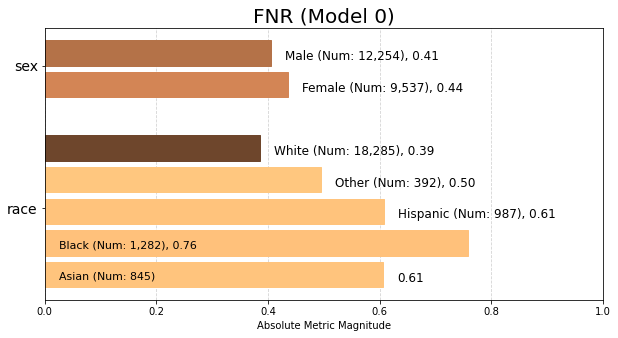

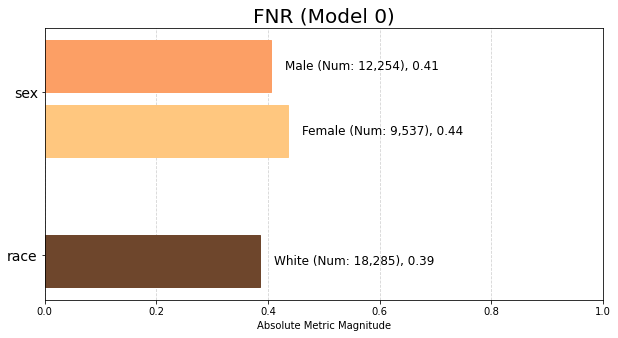

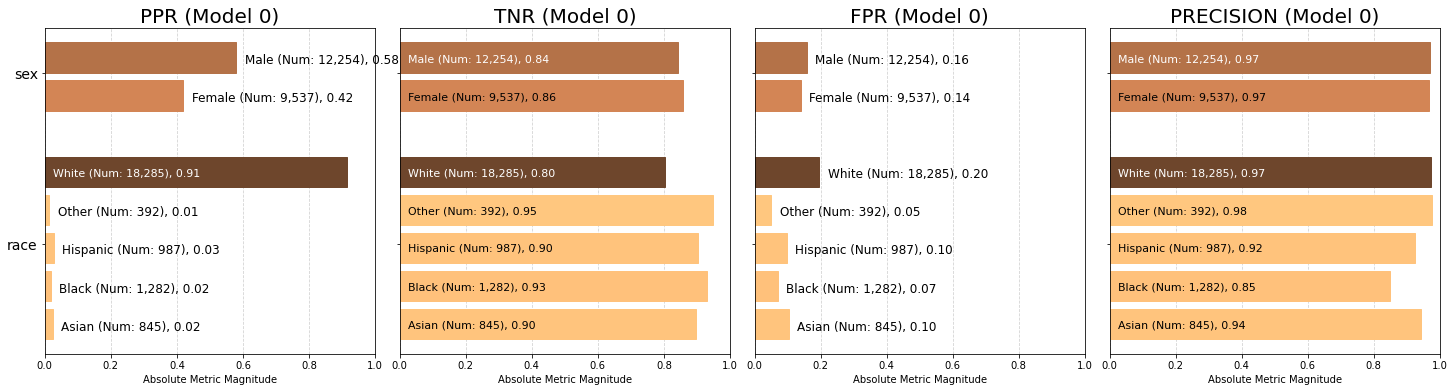

<Figure size 432x288 with 0 Axes>

In [48]:
    # Calculamos diferentes gráficas para el conjunto de datos
    aqp = Plot()    
    # Plot de los valores de las metricas de grupo para FNR
    fnr = aqp.plot_group_metric(xtab, 'fnr')
    # Plot de los valores de las metricas de grupo para FNR eliminando poblaciones con umbral de individuos
    fnr = aqp.plot_group_metric(xtab, 'fnr', min_group_size=0.05)
    # Metricas de grupo para todas las elegidas
    p = aqp.plot_group_metric_all(xtab, metrics=['ppr','tnr','fpr','precision'], ncols=4)

3. Calculamos la tabla para las métricas de sesgo. Tomamos como referencia para el atributo raza el valor *White* y para el atributo sexo el valor *Male*. Recordemos que la métrica de sesgo se calcula utilizando la siguiente fórmula:

\begin{equation*} 
\text{Métrica Grupo }_{G(a_o)} =\frac{\text{Métrica Grupo }{a_o}}{\text{Métrica Grupo }{a_r}}.
\end{equation*}

In [49]:
    # Calculamos las metricas de sesgo
    b = Bias()
    # Establecemos los atributos de referencia
    bdf = b.get_disparity_predefined_groups(xtab, original_df=dataset_law, ref_groups_dict={'race':'White', 
          'sex':'Male'}, alpha=0.05, mask_significance=True)
    calculated_disparities = b.list_disparities(bdf)
    disparity_significance = b.list_significance(bdf)
    # Mostramos la tabla de metricas de sesgo
    print(bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance])

get_disparity_predefined_group()
  attribute_name attribute_value  ppr_disparity  pprev_disparity  \
0           race           Asian       0.026989         0.584014   
1           race           Black       0.021253         0.303123   
2           race        Hispanic       0.029528         0.547030   
3           race           Other       0.015234         0.710603   
4           race           White       1.000000         1.000000   
5            sex          Female       0.723713         0.929893   
6            sex            Male       1.000000         1.000000   

   precision_disparity  fdr_disparity  for_disparity  fpr_disparity  \
0             0.970348       2.072854       0.884611       0.522862   
1             0.873038       5.593725       0.670961       0.353732   
2             0.949093       2.841922       0.787846       0.493345   
3             1.002264       0.918070       0.795819       0.258122   
4             1.000000       1.000000       1.000000       1.000000

Mostraremos las gráficas de la disparidad:

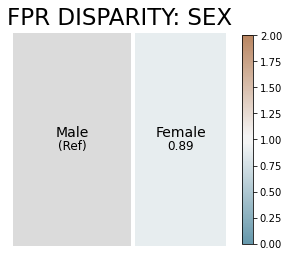

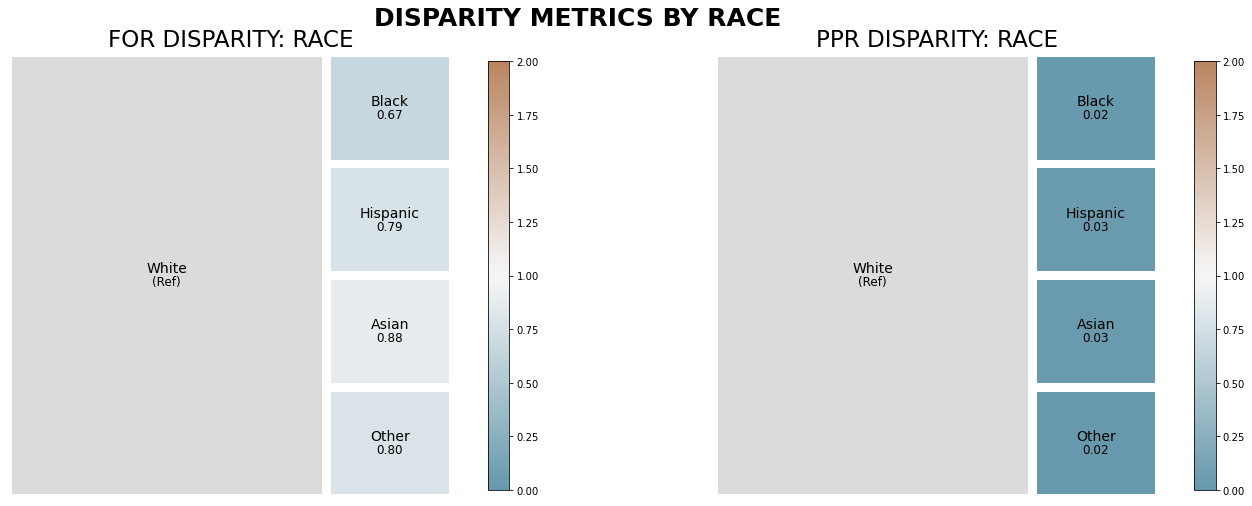

In [50]:
    aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='sex', significance_alpha=0.05)
    j = aqp.plot_disparity_all(bdf, metrics=['for_disparity', 'ppr_disparity'], attributes=['race'], 
                               significance_alpha=0.05)

4. Finalmente usamos $\tau=0.8$ para calcular si se cumplen o no los diferentes criterios de justicia implementados en Aequitas. Decidiremos si cumple o no el criterio de justicia basándonos en la ya presentada fórmula:

\begin{equation}
\tau \leq \text{Métrica de sesgo }_{G} \leq \frac{1}{\tau}, \quad \tau \in (0,1].
\end{equation}

In [51]:
    # Definimos las medidas de equidad a partir de la tabla de metricas de sesgo
    f = Fairness()
    # Establecemos el valor del umbral con la variable tau
    fdf = f.get_group_value_fairness(bdf, tau=0.8)
    #parity_detrminations = f.list_parities(fdf)
    # Tabla con si se cumplen las medidas de equidad para cada atributo
    gaf = f.get_group_attribute_fairness(fdf)
    print(gaf)

INFO:root:get_group_value_fairness...
INFO:root:get_group_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness
INFO:root:fill_groupby_attribute_fairness


   model_id score_threshold attribute_name  Statistical Parity  Impact Parity  \
0         0      binary 0/1           race               False          False   
1         0      binary 0/1            sex               False           True   

   FDR Parity  FPR Parity  FOR Parity  FNR Parity  TPR Parity  TNR Parity  \
0       False       False       False       False       False        True   
1        True        True        True        True        True        True   

   NPV Parity  Precision Parity  TypeI Parity  TypeII Parity  Equalized Odds  \
0       False              True         False          False           False   
1        True              True          True           True            True   

   Unsupervised Fairness  Supervised Fairness  
0                  False                False  
1                  False                 True  


Podemos mostrar las gráficas para las métricas de sesgo, pero esta vez usando los colores verde y rojo indicando si cumplen o no la disparidad para el umbral establecido.

En el ámbito del problema dado que las predicciones se utilizan para tomar decisiones de asistenciales (proporcionar esta asistencia a los individuos que son falsos positivos no les perjudicará), así que deberemos tener en cuenta las tasas de falsas omisiones (FOR) y las tasas de falsos negativos (FNR).

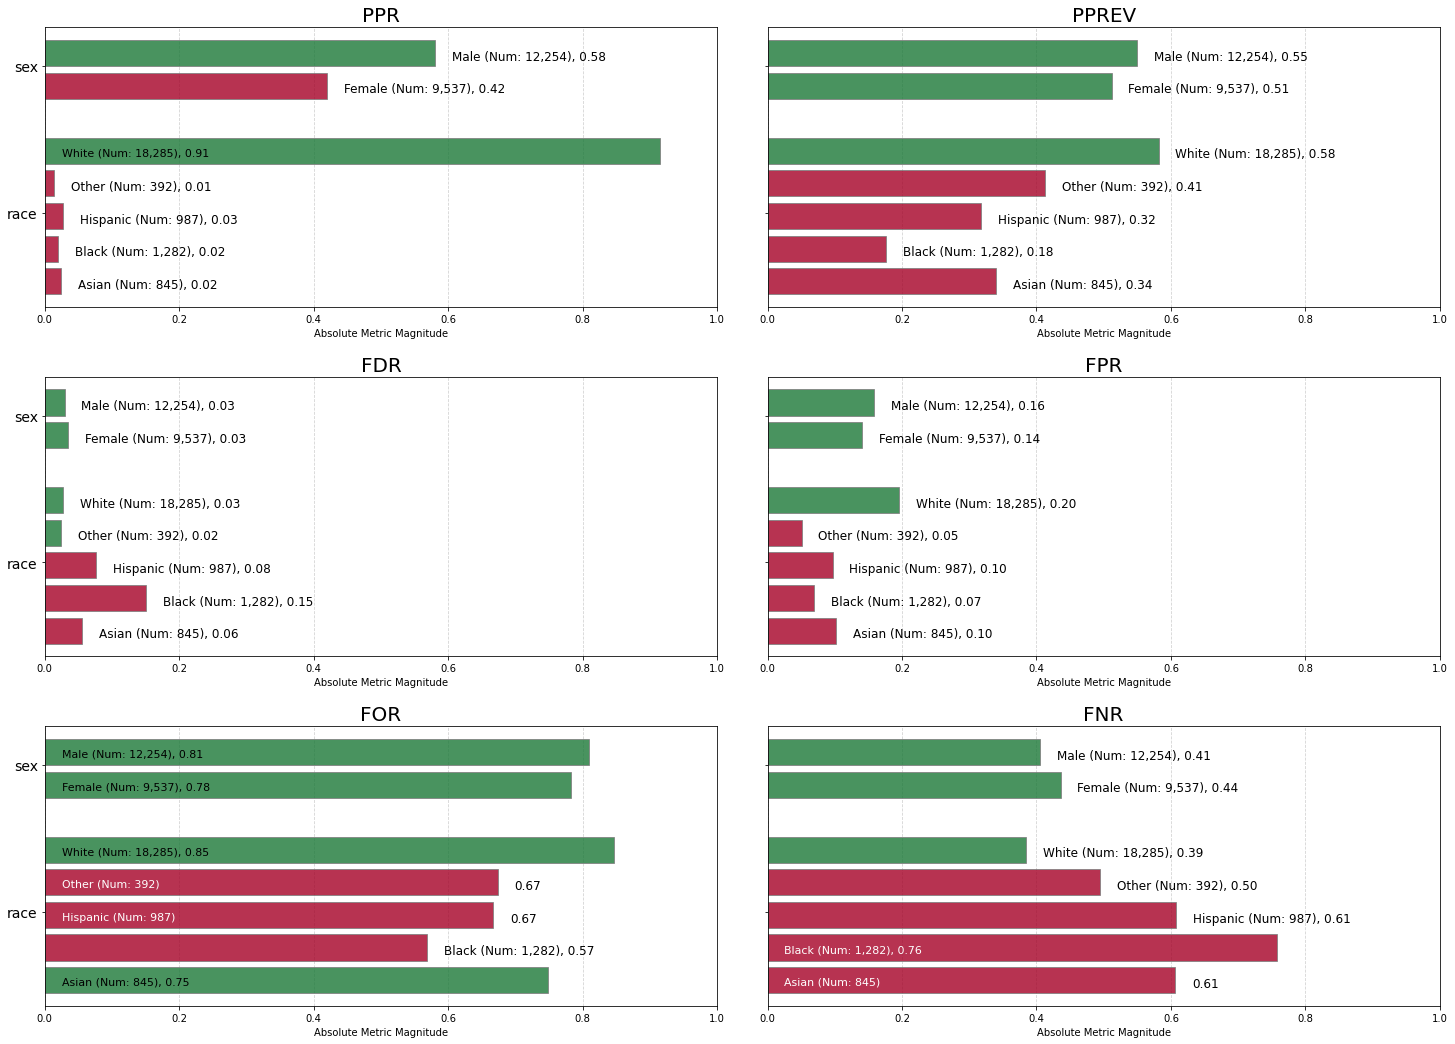

<Figure size 432x288 with 0 Axes>

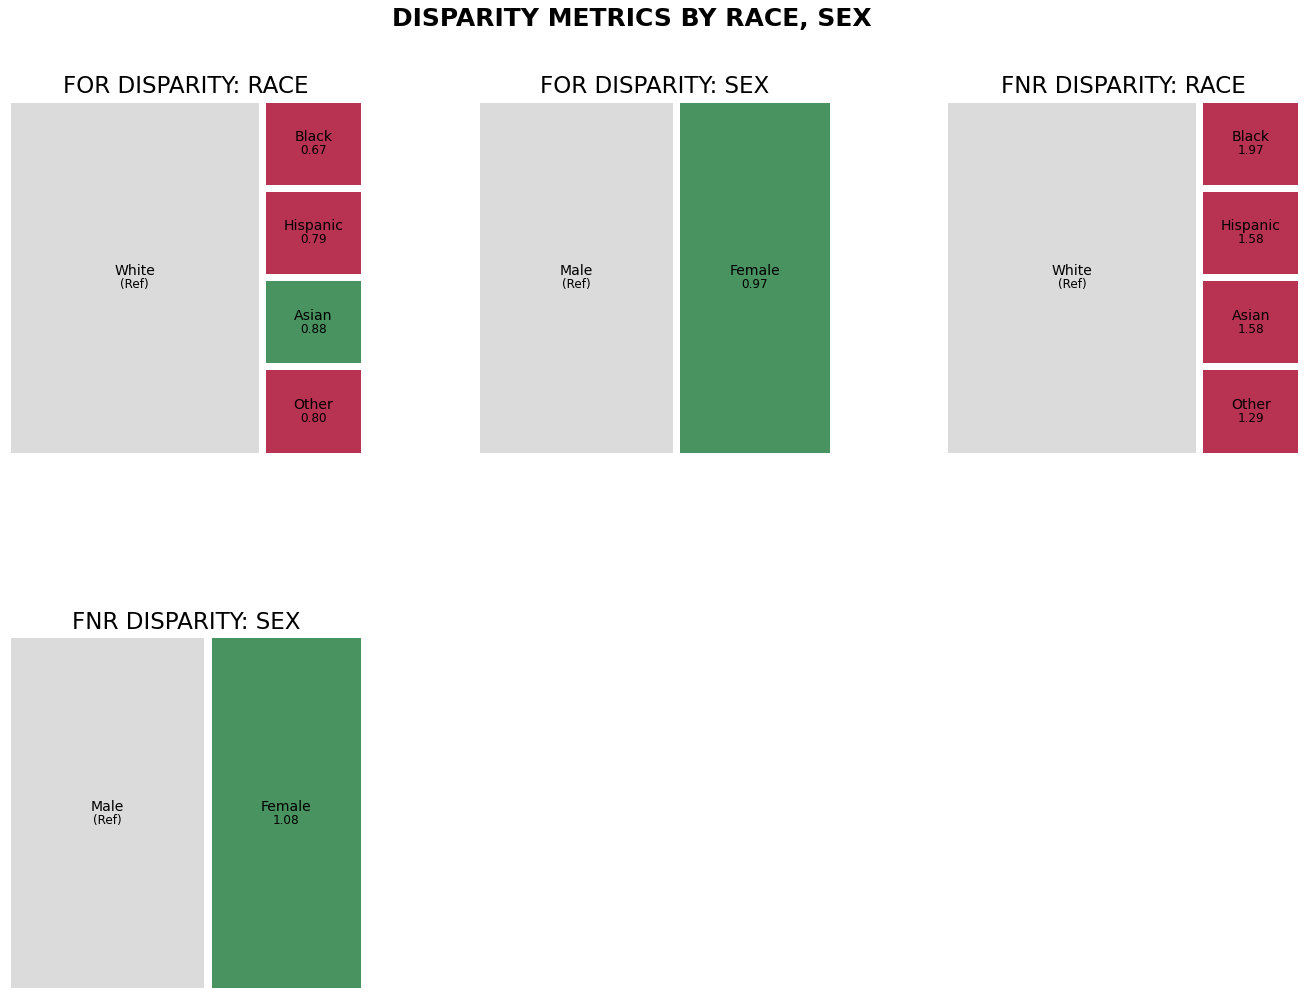

In [52]:
    # Metricas de grupo y de sesgo una vez aplicados los umbrales de equidad
    fg = aqp.plot_fairness_group_all(fdf, ncols=2, metrics = ['ppr','pprev','fdr','fpr','for','fnr'])
    m = aqp.plot_fairness_disparity_all(fdf, metrics=['for','fnr'], attributes=['race','sex'])